In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"



import sys
sys.path.append("/home/jdli/transpec")

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

from tqdm import tqdm
import joblib 

from kvxp.kvxp import xp2label, xp2label_attn, xp2label_nn, xp2label_seg
from kvxp.data import GXP_5lb, GXP_AP_4lb
from matplotlib.colors import LogNorm
import cmasher as cmr
cmap = cmr.dusk


# plt.style.use('default')
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))

In [26]:
def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../docs/models/scaler_labels_0208.gz', 
                        bias=2, scale_ext=10):
    scaler_labels = joblib.load(scaler_name)
    
    y   = scaler_labels.inverse_transform(y_hat/scale_ext-bias)
    e_y = (e_y_hat * scaler_labels.scale_)/scale_ext
    return y, e_y

def recover_dist_label(y_hat, e_y_hat):
    norm = np.array([1e-2, 15., 10., 50.])
    shift_norm = np.array([25., 25., 25., 25.])
    y = (y_hat-shift_norm)/norm
    e_y = e_y_hat/norm
    return y, e_y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     model_type='attn',
                     n_input=110, n_hi=7514, n_output=4, n_dim=128, 
                     n_head=8, n_layer=8, device=torch.device('cuda:0'), 
                     mask_ap=False):
    
#     if model_type == 'attn':
#         model = xp2label(n_encoder_inputs=n_input, n_outputs=n_output,).to(device)
        
#     elif model_type == 'nn':
#         model = xp2label_nn(n_encoder_inputs=n_input, n_outputs=n_output, channels=n_dim).to(device)
#     model.load_state_dict(torch.load(model_name))
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            if not mask_ap:
                output = model(data['x'][:,:n_input+n_hi])
            else:
                x = data['x'][:,:n_input+n_hi]
                x[:,n_input:]=0
                output = model(x)
                
            out_lst   = np.append(out_lst,  output[:,:4].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y, e_y = transcale_method(out_lst, out_lst)
    return {'labels':y, 'source_id':id_lst}


def infer_4lbs_model_err(model_name, data_loader, transcale_method=recover_scale_label,
                         n_input=113, n_output=8, n_dim=128, 
                         n_head=8, n_layer=8, device=torch.device('cuda:0')):
    
    model = xp2label(n_encoder_inputs=n_input, n_outputs=n_output, 
                     channels=n_dim, n_heads=n_head, n_layers=n_layer).to(device)
    model.load_state_dict(torch.load(model_name))
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            output = model(data['x'])
            out_lst   = np.append(out_lst,   output[:,:4].cpu().numpy())
            e_out_lst = np.append(e_out_lst, output[:,4:].cpu().numpy())
            # y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst, e_out_lst = np.array(out_lst).reshape(-1,4), np.array(e_out_lst).reshape(-1,4)
    # y, e_y = recover_label(out_lst, e_out_lst)
    y, e_y = transcale_method(out_lst, e_out_lst)
    return {'labels':y, 'e_labels':e_y, 'source_id':id_lst}


In [3]:
data_dir = "/data/jdli/gaia/"

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")

# tr_file = "ap17_wise_xp_66701_allstand1225.npy"
tr_file = "ap_xp_13286.npy"


device = torch.device('cuda:1')
# device = torch.device('cpu')
TOTAL_NUM = 6000
BATCH_SIZE = int(2**14)

gdata  = GXP_AP_4lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=BATCH_SIZE)

gdata[0]

{'x': tensor([-0.7484,  0.5805,  0.5288,  ...,  0.9211,  0.9239,  0.9191],
        device='cuda:1'),
 'y': tensor([20.4627, 20.4187, 20.2199, 20.9735], device='cuda:1'),
 'e_y': tensor([0.0649, 0.1663, 0.0539, 0.1880], device='cuda:1'),
 'id': 429519480056179328}

In [21]:
def remove_prefix(state_dict, unwanted_prefix = '_orig_mod.'):

    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            
    return state_dict

preflix_name = "sp2_4l_xpap_{:d}_ep{:d}.pt"

# model_dir =data_dir + "model/0127_nn/"
model_dir = data_dir + "model/0202_xpap_atnn/"

model_name = preflix_name.format(*[0,150])
# model_name = "val_temp.pt"

print(model_dir+model_name)

###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

INPUT_LEN = 110
n_hi = 7514
n_outputs = 4
n_dim = 32
n_head = 4
n_layer = 4

rdf_tot      = pd.DataFrame([])
pred_names   = ['teff_cross', 'logg_cross',  'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    if fold==0:
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        
        model = xp2label_seg(
            n_encoder_inputs=INPUT_LEN, n_outputs=n_outputs, 
            channels=n_dim, n_heads=n_head, n_layers=n_layer
                ).to(device)
        
        tr_dict = torch.load(model_dir+model_name)
        
        tr_dict = remove_prefix(torch.load(model_dir+model_name))
        model.load_state_dict(tr_dict)

        labels_infer = infer_4lbs_model(
            model, val_loader, device=device, 
            n_input=INPUT_LEN, 
            transcale_method=recover_scale_label
        )

        rdf = pd.DataFrame(labels_infer['labels'], columns=pred_names)
        rdf = rdf.assign(source_id=labels_infer['source_id'])
        rdf_tot = pd.concat([rdf_tot, rdf], ignore_index=True)

        print(len(rdf_tot))

/data/jdli/gaia/model/0202_xpap_atnn/sp2_4l_xpap_0_ep150.pt
FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]

2658


In [15]:
def cost_mse(pred, tgt):
    cost = torch.nn.MSELoss(reduction='mean')
    return cost(pred, tgt)

cost_mse(model(gdata[100]['x']), gdata[100]['y'].view(-1, 4))

tensor(0.1816, device='cuda:1', grad_fn=<MseLossBackward0>)

38.895143869382
0.10294383792900917
0.06780058156785874
0.03785645238151196


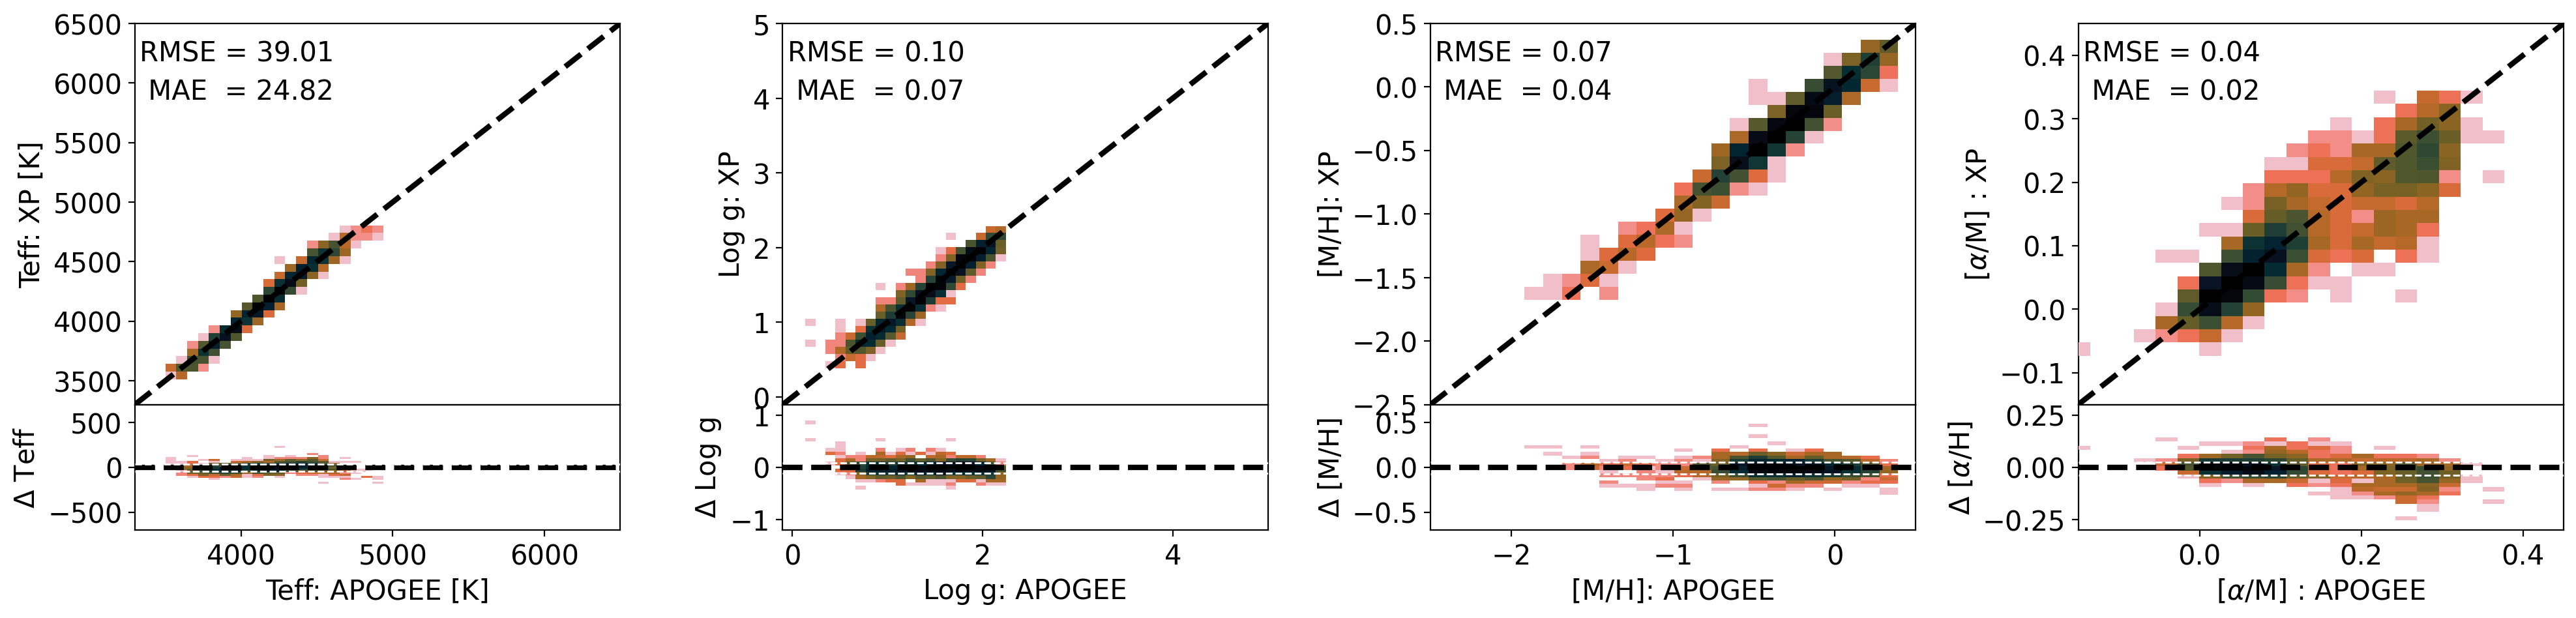

In [22]:
rdf_val = rdf_tot.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))


from kvxp.vis import *
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'

vdf = rdf_val.copy()
# print(len(rdf_tot[~mask]))

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[pred_names[i]],
        xrange=xranges[i], bins=20,
    )
    
    print(np.std(rdf_val[true_names[i]]-rdf_val[pred_names[i]]))
    
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()
# fig.savefig("../fig/compare4d.png")

# Inference with masking APOGEE

In [38]:
def remove_prefix(state_dict, unwanted_prefix = '_orig_mod.'):

    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            
    return state_dict

preflix_name = "sp2_4l_xpap_{:d}_ep{:d}.pt"
model_dir = data_dir + "model/0202_xpap_atnn/"

model_name = preflix_name.format(*[0,150])

print(model_dir+model_name)

###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

INPUT_LEN = 110
n_hi = 7514
n_outputs = 4
n_dim = 32
n_head = 4
n_layer = 4

rdf_tot      = pd.DataFrame([])
pred_names   = ['teff_cross', 'logg_cross',  'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    if fold==0:
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        
        idx_mask = torch.arange(110,220,1, device=device)
        
        model_inf = xp2label_seg_inference(
            n_encoder_inputs=INPUT_LEN, n_outputs=n_outputs, 
            channels=n_dim, n_heads=n_head, n_layers=n_layer,
            coef_mask=idx_mask, device=device
                ).to(device)
        
        tr_dict = torch.load(model_dir+model_name)
        tr_dict = remove_prefix(torch.load(model_dir+model_name))
        
        model_inf.load_state_dict(tr_dict)

        labels_infer = infer_4lbs_model(
            model_inf, val_loader, device=device, 
            n_input=INPUT_LEN, 
            transcale_method=recover_scale_label,
            mask_ap=False
        )

        rdf = pd.DataFrame(labels_infer['labels'], columns=pred_names)
        rdf = rdf.assign(source_id=labels_infer['source_id'])
        rdf_tot = pd.concat([rdf_tot, rdf], ignore_index=True)

        print(len(rdf_tot))

/data/jdli/gaia/model/0202_xpap_atnn/sp2_4l_xpap_0_ep150.pt
FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]

2658


70.02503976172854
0.18152712503255816
0.15935724650871283
0.05495347410739475


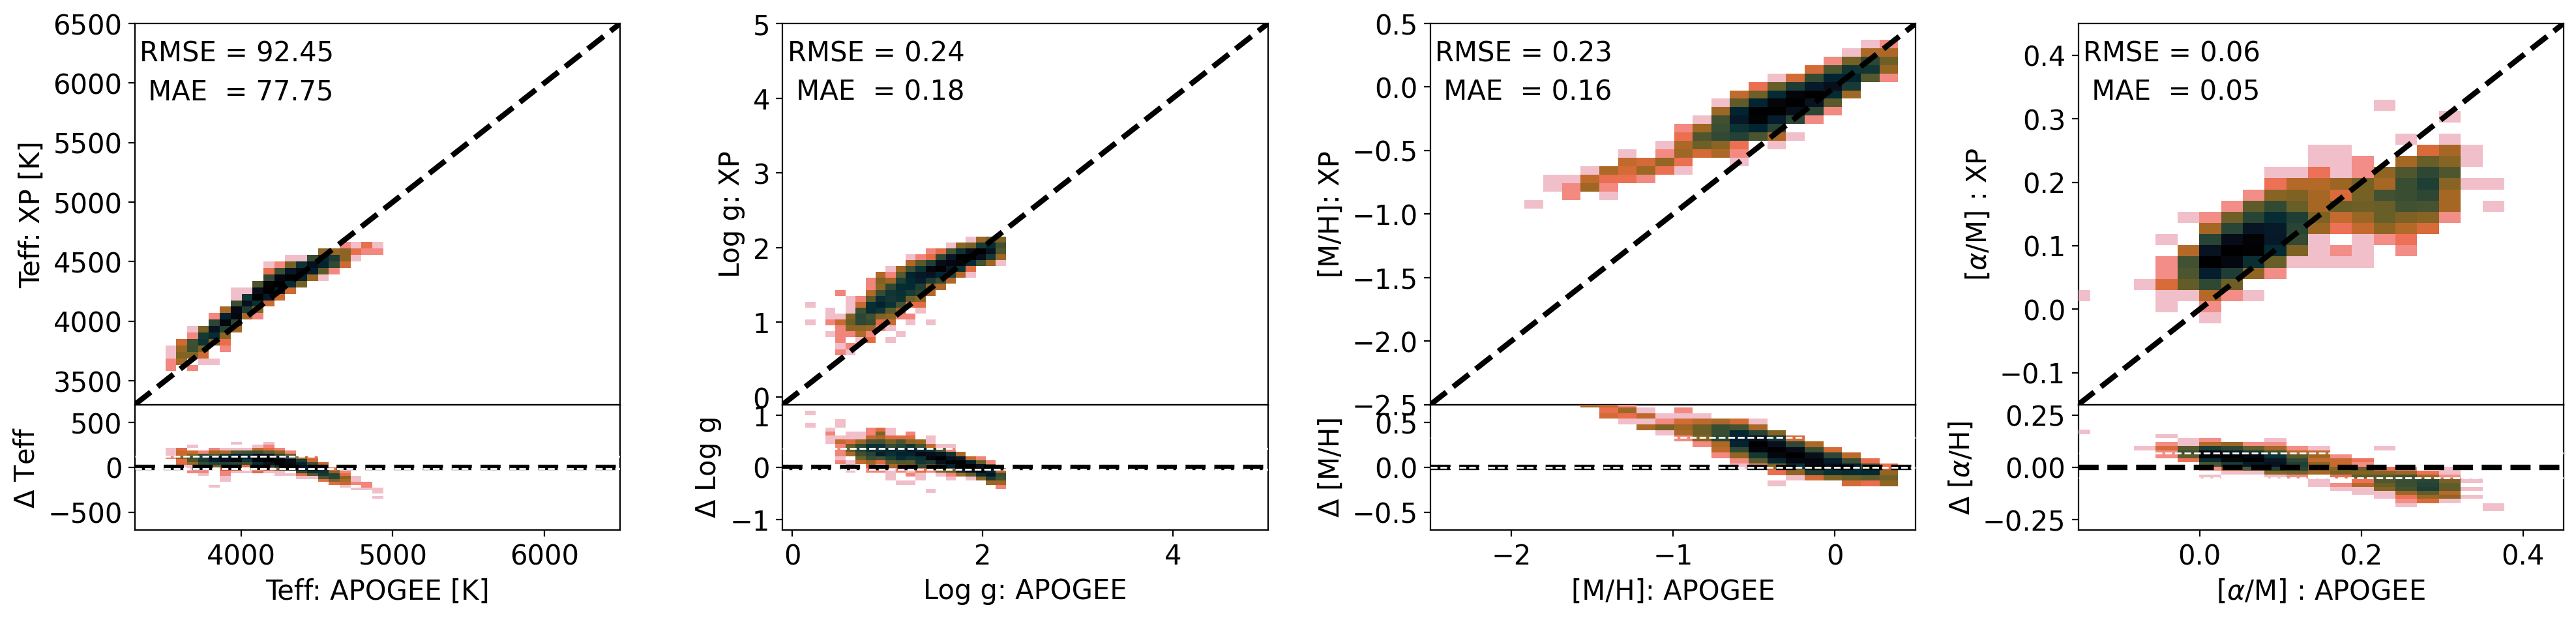

In [39]:
rdf_val = rdf_tot.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))


from kvxp.vis import *
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'

vdf = rdf_val.copy()
# print(len(rdf_tot[~mask]))

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[pred_names[i]],
        xrange=xranges[i], bins=20,
    )
    
    print(np.std(rdf_val[true_names[i]]-rdf_val[pred_names[i]]))
    
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()
# fig.savefig("../fig/compare4d.png")

1013.0712416223167
1.8940851953365572
0.9374923000912552
0.265591532145544


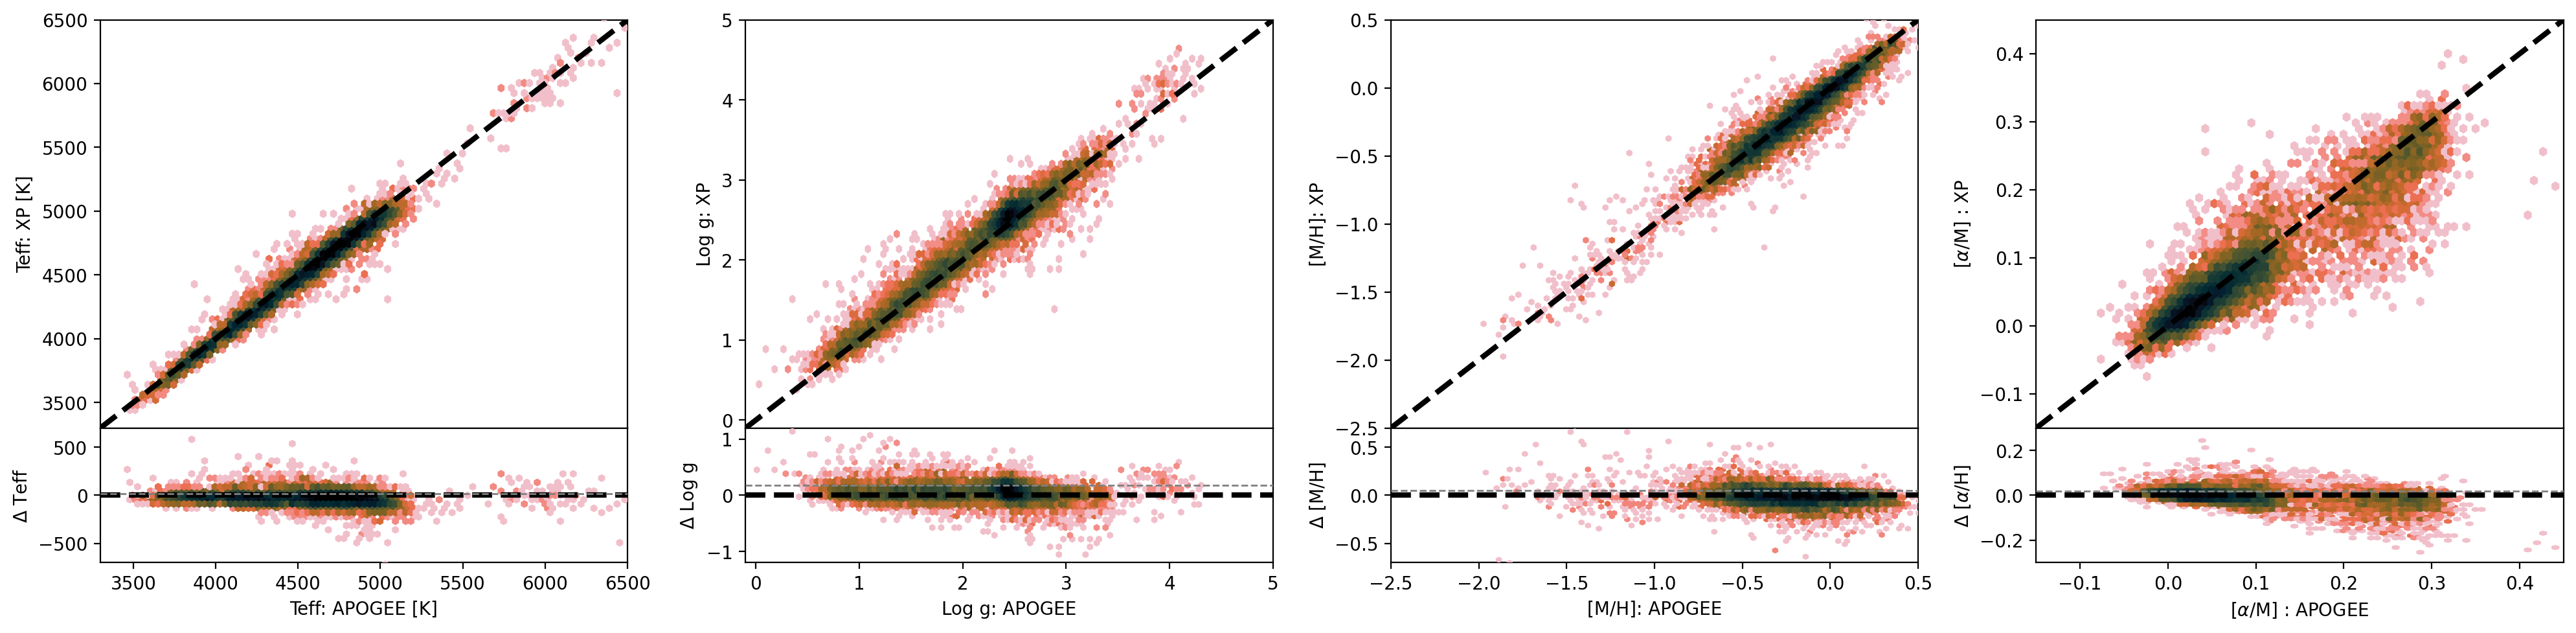

In [25]:
rdf_val = rdf_tot.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))
vdf = rdf_val.copy()

from kvxp.vis import *

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf_val[true_names[i]], rdf_val[pred_names[i]],
        xrange=xranges[i], bins=100,
    )
    
    print(np.std(rdf_val[true_names[i]]-rdf_val[pred_names[i]]))
    
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()
# fig.savefig("../fig/compare4d.png")

In [200]:
preflix_name = "sp2_4l_allstand_nll_{:d}_ep{:d}.pt"
model_dir =data_dir + "model/0119_4l_err_pen/"

# preflix_name = "sp2_4l_allstand_nll_{:d}_ep{:d}.pt"
# model_dir = data_dir + "model/1226_4l_err_pen/"

# fold_name = [1 for i in range(5)]
fold_name = [i for i in range(5)]

epochs = [100]

model_names = [preflix_name.format(*[f, e]) for f in fold_name for e in epochs]
print(model_names)


['sp2_4l_allstand_nll_0_ep100.pt', 'sp2_4l_allstand_nll_1_ep100.pt', 'sp2_4l_allstand_nll_2_ep100.pt', 'sp2_4l_allstand_nll_3_ep100.pt', 'sp2_4l_allstand_nll_4_ep100.pt']


In [201]:
model = xp2label(
    n_encoder_inputs=113, n_outputs=8, 
    channels=128, n_heads=8, n_layers=8
).to(device)

model.load_state_dict(torch.load(model_dir+model_names[0]))

idx = 1000

with torch.no_grad():
    y = model(gdata[idx]['x'])
    tgt = gdata[idx]['y']
    print(y)
    print(tgt)

    cost = torch.nn.GaussianNLLLoss(reduction='mean', eps=1e-6)

    print(cost(y[:,:4], tgt, y[:,4:]))

tensor([[21.6958, 20.8031, 20.9398, 18.1707,  0.1913,  0.2924,  0.2388,  0.8499]],
       device='cuda:0')
tensor([21.2451, 20.3189, 21.5217, 18.1622], device='cuda:0')
tensor(-0.1496, device='cuda:0')


In [202]:
###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
INPUT_LEN = 55*2+3
n_outputs = 8
n_dim = 128
n_head = 8
n_layer = 8
device = torch.device('cuda:0')

rdf_tot      = pd.DataFrame([])
pred_names   = ['teff_cross', 'logg_cross',  'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    valid_subsampler = SubsetRandomSampler(valid_ids)
    val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    
    labels_infer = infer_4lbs_model_err(model_dir+model_names[fold], val_loader, device=device,  
                                        transcale_method=recover_scale_label)

    
    rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['e_labels']], 
                    columns=pred_names+e_pred_names)
    rdf = rdf.assign(source_id=labels_infer['source_id'])
    rdf_tot = pd.concat([rdf_tot, rdf], ignore_index=True)
    
    print(len(rdf_tot))

FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


13339
FOLD 1
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


26678
FOLD 2
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


40017
FOLD 3
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


53356
FOLD 4
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]

66695


In [107]:
16*1e9 / (13339/2) / 3600 / 24

27.76597723745186

In [130]:
# badname = "ap17_wise_xp_5667bad.npy"

# badata  = GXP_5lb(
#     data_dir+badname, 
#     part_train=False,  device=device,
# )
# bad_loader = DataLoader(badata, batch_size=4096)

# labels_infer = infer_4lbs_model_err(model_dir+model_names[0], bad_loader, device=device)


# # bad_df = pd.DataFrame(labels_infer['labels'], columns=['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross'])
# bad_df = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['e_labels']], 
#                         columns=['teff_cross', 'logg_cross',  'moh_cross', 'aom_cross', 
#                                 'e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
#                       )
# bad_df = bad_df.assign(source_id=labels_infer['source_id'])

# rdf_tot = pd.concat([rdf_tot, bad_df], ignore_index=True)
# rdf_tot.shape


In [5]:
# data_dir = "/data/jdli/gaia/"

# out_name = data_dir+"APtransXP_0120_4lbs_err_55coefs.csv"

# rdf_tot = pd.read_csv(out_name)

(66695, 54) Index(['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross', 'e_teff_cross',
       'e_logg_cross', 'e_moh_cross', 'e_aom_cross', 'source_id',
       'source_id_y', 'bp_coef', 'e_bp_coef', 'rp_coef', 'e_rp_coef',
       'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG',
       'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR',
       'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1',
       'qph_w2', 'Qfl_J', 'Qfl_H', 'Qfl_K', 'snr_bp', 'snr_bp10', 'snr_bp55',
       'snr_rp', 'snr_rp10', 'snr_rp55'],
      dtype='object')


<AxesSubplot:ylabel='Frequency'>

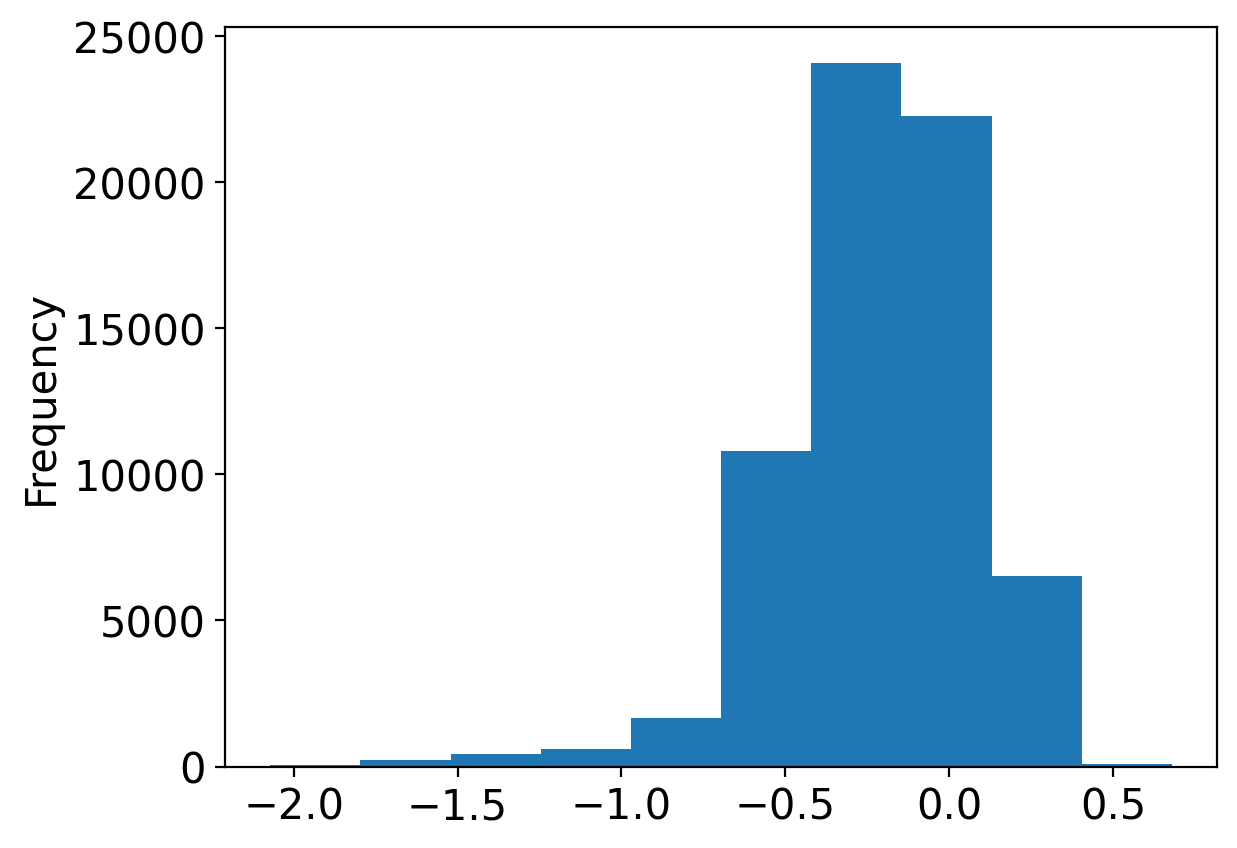

In [203]:
out_name = data_dir+"APtransXP_0120_4lbs_err_55coefs.csv"

rdf_tot = rdf_tot.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))

print(rdf_tot.shape, rdf_tot.columns)

# rdf_tot.to_csv(out_name, index=False)

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']

rdf_tot = rdf_tot.dropna(subset=pred_names)
rdf_tot.shape

rdf_tot['moh_cross'].plot(kind='hist') #e_teff_cross, e_logg_cross, e_moh_cross, e_aom_cross

In [ ]:
rdf_tot.to_csv(out_name, index=False)

0


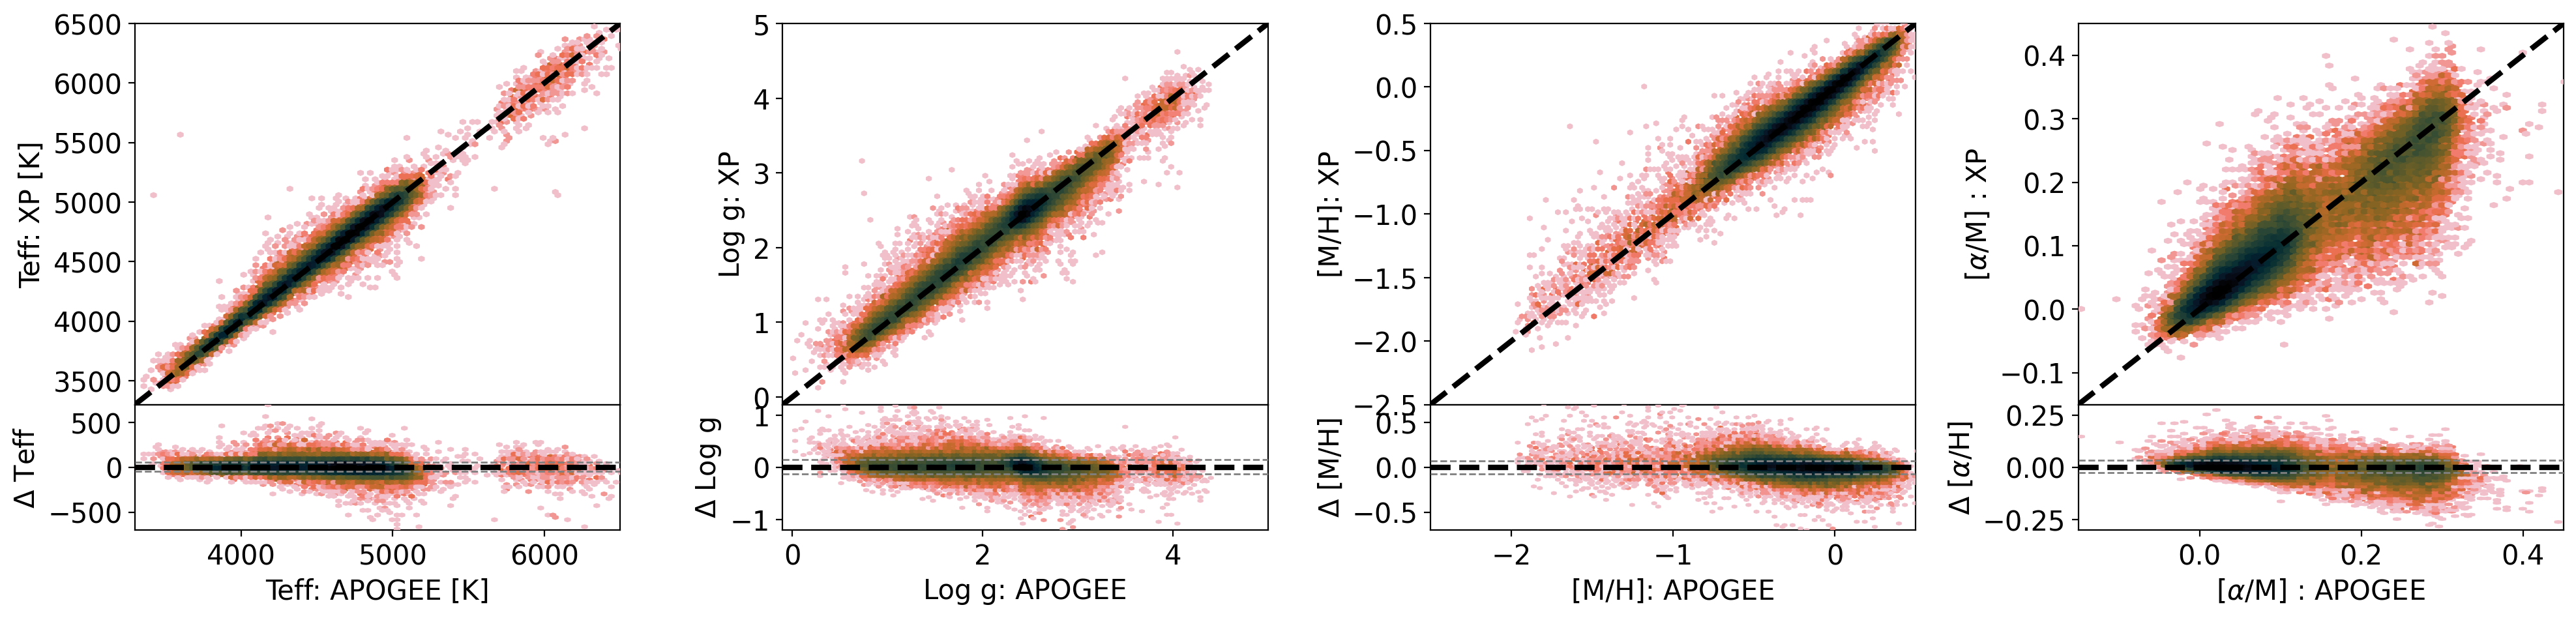

In [209]:
from transGaia.vis import *
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'


mask = (rdf_tot['e_aom_cross']<1)
vdf = rdf_tot[mask].copy()
print(len(rdf_tot[~mask]))

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']


xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], vdf[true_names[i]], vdf[pred_names[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()
# fig.savefig("../fig/compare4d.png")

In [133]:
# e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']


# rdf_tot = rdf_tot.dropna(subset=pred_names+e_pred_names)
# rdf_tot.shape

# vdf = rdf_tot.copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


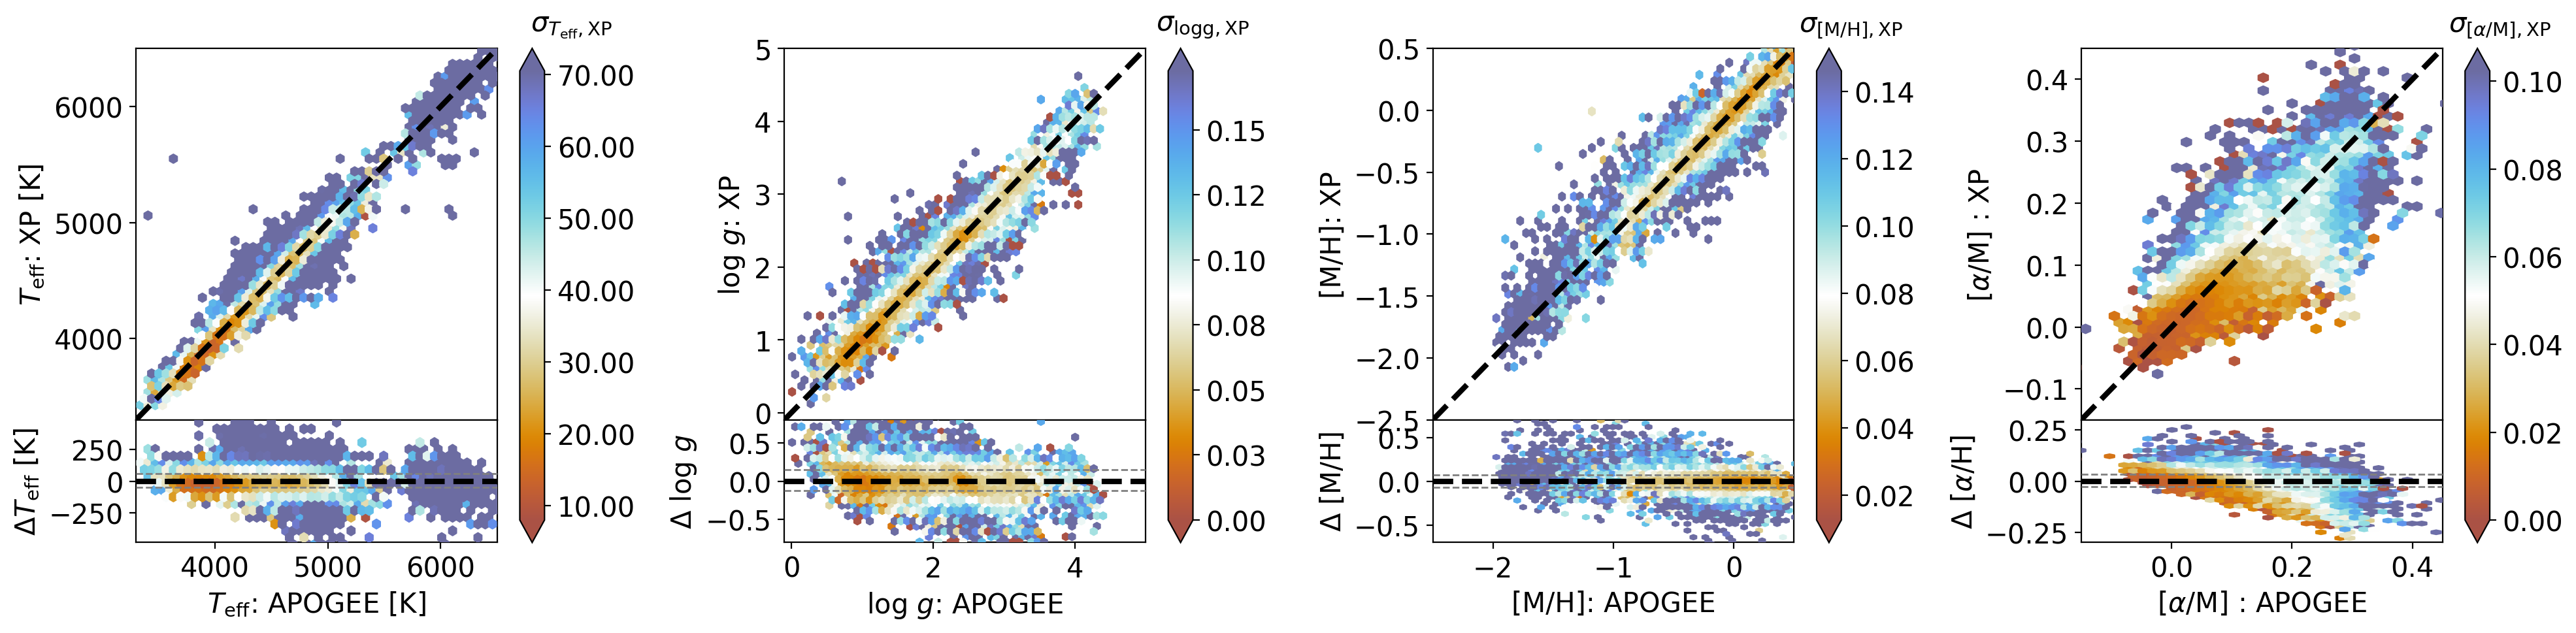

In [210]:
from transGaia.vis import *
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.2%}'.format(x)

%load_ext autoreload
%autoreload 2

rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

errors  = [r'$\sigma_{T_{\rm eff}, {\rm XP}}$', r'$\sigma_{\rm log g, XP}$', r'$\sigma_{\rm [M/H], XP}$', r'$\sigma_{[\alpha/{\rm M}], {\rm XP}}$']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-480, 480],  [-0.8, 0.8],  [-0.7, 0.7], [-0.3, 0.3]]
xlabels = [r'$T_{\rm eff}$: APOGEE [K]', r'log $g$: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$: XP [K]', r'log $g$: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta T_{\rm eff}$ [K]', r'$\Delta$ log $g$', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2, img = draw_compare(
        axs[i], vdf[true_names[i]], vdf[pred_names[i]], C=vdf[e_pred_names[i]],
        xrange=xranges[i], bins=50, if_hex=True, cmap='cmr.prinsenvlag',
        vmin=np.nanpercentile(vdf[e_pred_names[i]], 5), 
        vmax=np.nanpercentile(vdf[e_pred_names[i]], 95), 
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    
    fmt = lambda x, _: f"{x:.2f}" if i>=1 else None

    clb = plt.colorbar(img, ax=ax1, extend='both', format=fmt)
    clb.set_label(errors[i], rotation=0, y=1.13, labelpad=-35)

plt.tight_layout()

# fig.savefig("../fig/compare4d_error.png")

In [194]:
def chi(pred, tgt, e_pred, e_tgt):
    return (pred-tgt)/np.sqrt(e_pred**2+e_tgt**2)
    
pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']


rdf_tot = rdf_tot.dropna(subset=e_pred_names+pred_names)
rdf_tot.shape

mask = (rdf_tot['e_aom_cross']<1)
vdf = rdf_tot[mask].copy()
print(len(rdf_tot[~mask]))
    

n_pars = len(pred_names)

chi_arr = chi(vdf[pred_names].values, vdf[true_names].values,
              vdf[e_pred_names].values, vdf[e_true_names].values, )



0


In [195]:
def kl_divergence(mean1, std1, mean2, std2):
  # Compute the KL divergence between two normal distributions with means mean1 and mean2,
  # and standard deviations std1 and std2.
    var1 = std1 ** 2
    var2 = std2 ** 2
    return 0.5 * (np.log(var2 / var1) + (var1 + (mean1 - mean2) ** 2) / var2 - 1)

# Compute the KL divergence between two normal distributions with means 0 and 1,
# and standard deviations 1 and 2.
for i in range(4):

    kl = kl_divergence(chi_arr[:,i].mean(), chi_arr[:,i].std(), 0, 1)
    print(kl)  # 0.35667494393873245

kl_divergence(chi_arr.mean(axis=0), chi_arr.std(axis=0), 0, 1)

2.238270385986294
5.275235837904599
1.11520411155603
3.4548230607704618


array([2.23827039, 5.27523584, 1.11520411, 3.45482306])

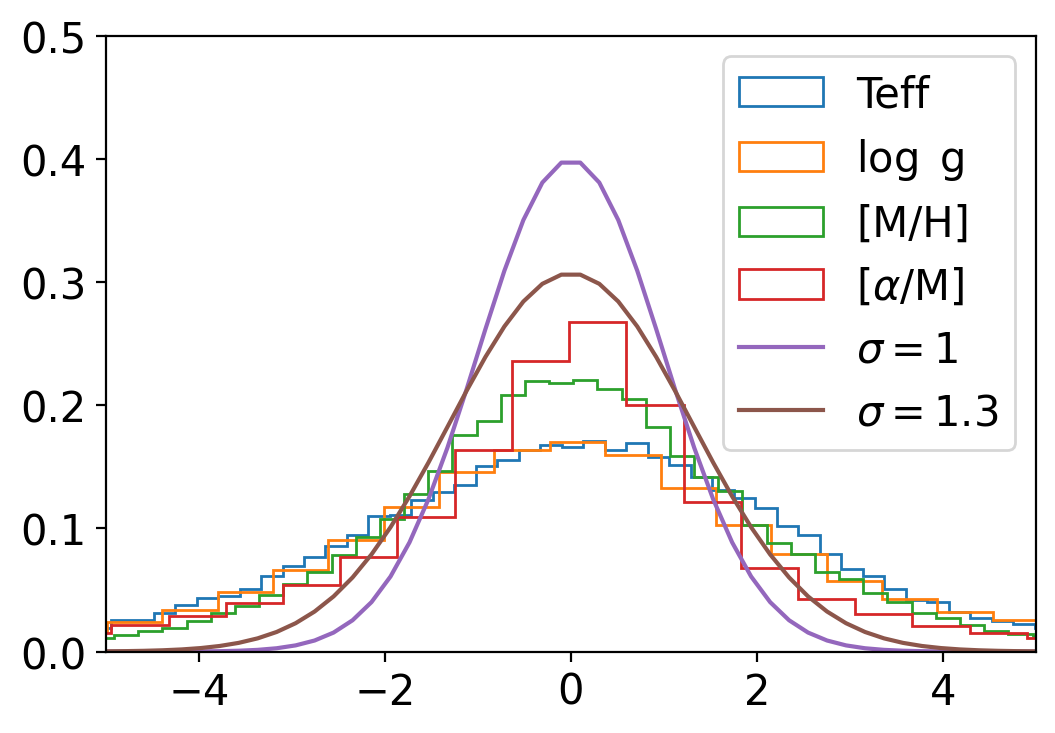

In [196]:
from scipy.stats import norm

labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

xx = np.linspace(-5, 5)
fig, ax = plt.subplots(1,1, figsize=(6,4))

for i in range(n_pars):
    ax.hist(chi_arr[:,i], histtype='step', label=labels[i], bins=200, density=True)
    ax.set_xlim([-5, 5]);

ax.plot(xx, norm.pdf(xx, loc=0, scale=1), label=r'$\sigma = 1$')
ax.plot(xx, norm.pdf(xx, loc=0, scale=1.3), label=r'$\sigma = 1.3$')
ax.set_ylim([0, 0.5]);
ax.legend();

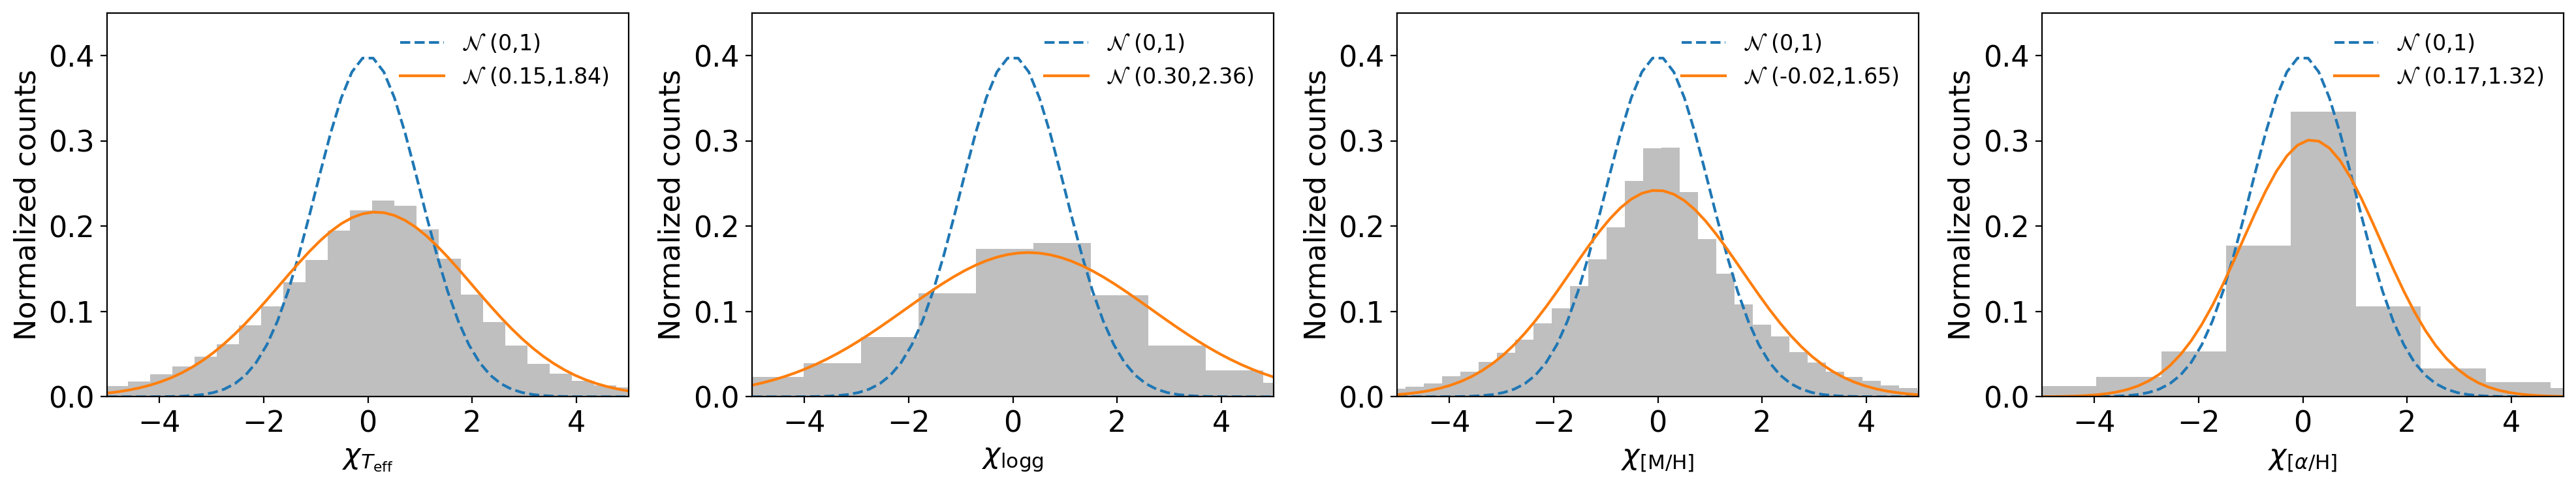

In [138]:
ft = 16
rcParams["font.size"] = ft
rcParams['font.family'] = 'sans-serif'

def draw_hist(ax, chi):
    ax.hist(chi, bins=100, alpha=0.5, density=True, color='grey')
    xx = np.linspace(-5, 5)
    ax.plot(xx, norm.pdf(xx, loc=0, scale=1), label=r'$\mathcal{N}$ (0,1)', ls='--')
    
    mu_chi, s_chi = np.nanmedian(chi), 0.5*(np.nanpercentile(chi, 84)-np.nanpercentile(chi, 16))
    ax.plot(xx, norm.pdf(xx, loc=mu_chi, scale=s_chi), label=r'$\mathcal{N}$ (%.2f,%.2f)'%(mu_chi, s_chi))
    ax.set_ylim([0, 0.45]);
    ax.set_xlim([-5, 5]);
    return ax

xlabels  = [r'$\chi_{T_{\rm eff}}$', r'$\chi_{\rm log g}$',
            r'$\chi_{\rm [M/H]}$', r'$\chi_{[\alpha/{\rm H}]}$']


fig, axs = plt.subplots(1,4, figsize=(5*4,4))

for i,ax in enumerate(axs):
    
    ax.set_ylabel('Normalized counts', fontsize=ft);    
    ax = draw_hist(ax, chi_arr[:,i])
    ax.set_xlabel(xlabels[i], fontsize=ft);
    ax.legend(fontsize=12, frameon=False, loc=1);
    
plt.tight_layout()
# fig.savefig('../fig/chi_4lbs.pdf')

# show inference results

In [229]:
# def draw_pars(ax1, ax2, teff, logg, moh, aom, gridsize=(50,50)):
#     cmap = plt.get_cmap('cmr.prinsenvlag_r')
#     img1 = ax1.hexbin(teff, logg, C=moh, cmap='cmr.prinsenvlag_r', gridsize=gridsize)
#     # ax2.set_xscale('log')
#     ax1.set_xlim([6500, 3100]);
#     ax1.set_ylim([4.5, -0.1]);
    
#     img2 = ax2.hexbin(moh, aom, gridsize=gridsize, 
#                       norm=colors.LogNorm(vmin=10, vmax=100), cmap='cmr.prinsenvlag_r', )
#     ax2.set_xlim([-2.5, 0.5]);
#     ax2.set_ylim([-0.3, 0.5]);
    
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(-2, 0.2))
#     sm.set_array([])
#     clb1 = plt.colorbar(sm, ax=ax1, extend='both', ticks=[-2.0, -1.5, -1.0, -0.5, 0.0]);
#     clb1.ax.set_yticklabels([-2.0, -1.5, -1.0, -0.5, 0.0]) 
#     clb1.set_label(r"[M/H]$_{\rm AP.}$", rotation=0, y=1.12, labelpad=-35)
    
#     clb2 = fig.colorbar(img2, ax=ax2, extend='max');
#     clb2.set_label(r"Counts", rotation=0, y=1.12, labelpad=-35)
#     # ax1.set_xlabel(r"$T_{\rm eff}$: APOGEE [K]");
#     # ax1.set_ylabel(r"$\log$ g: APOGEE");
#     # ax2.set_xlabel('[M/H]: APOGEE');
#     # ax2.set_ylabel(r'[$\alpha$/M]: APOGEE');
#     return ax1, ax2, clb1, clb2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


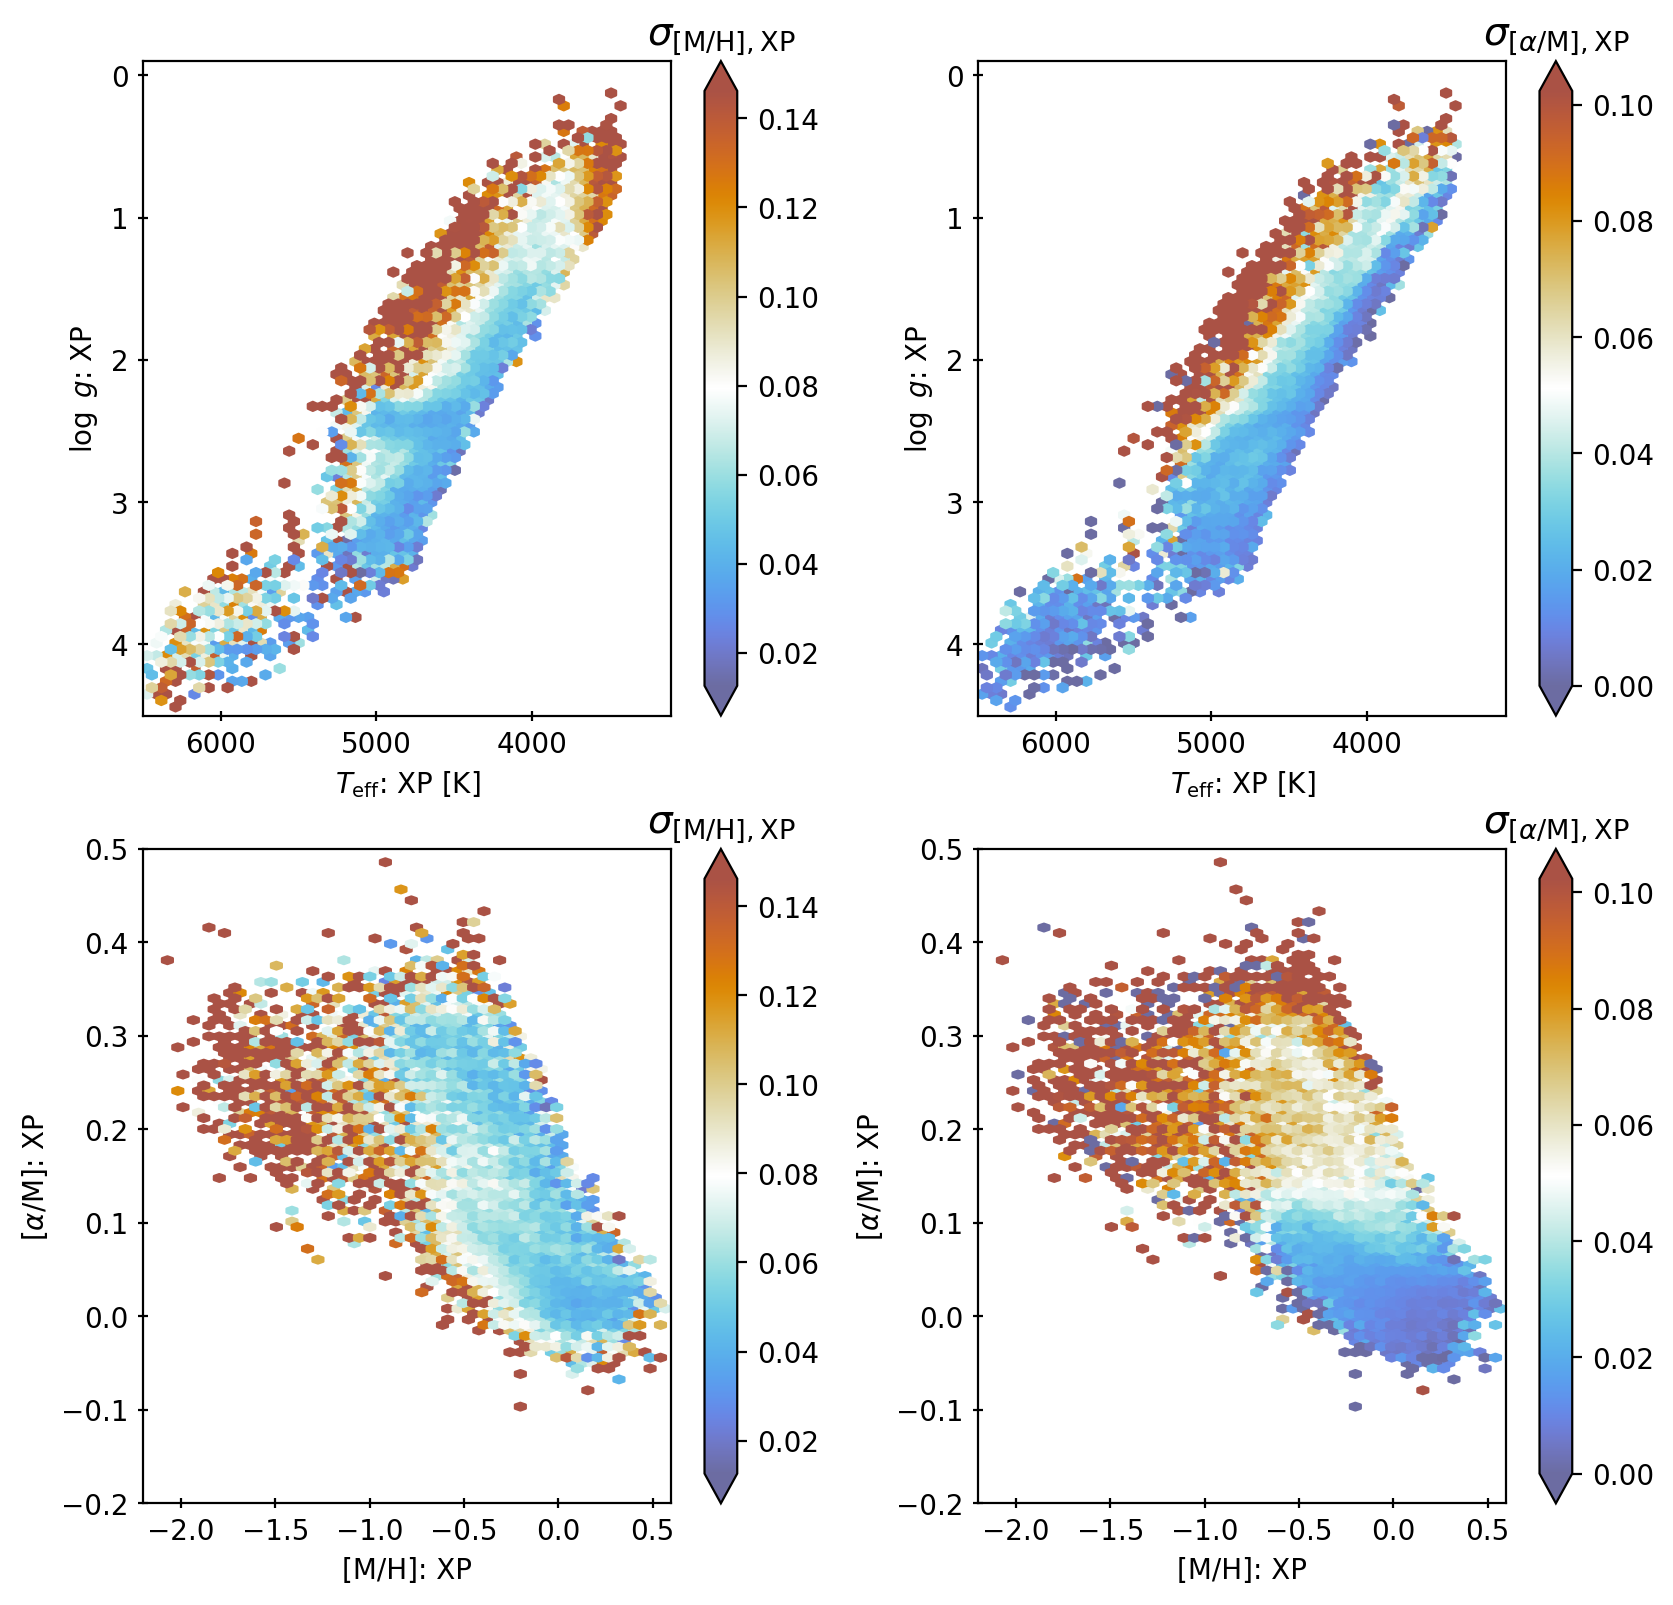

In [238]:
%load_ext autoreload
%autoreload 2
rcParams["font.size"] = 10

from transGaia.vis import draw_pars

fig, axs = plt.subplots(2,2, figsize=(8.5, 8))

ax1, ax2, ax3, ax4 = axs.ravel()

# clb2.ax.set_yticklabels([1e0, 1e1, 1e2]); 

ax1, ax3, _, _, clb1, clb3 = draw_pars(
    ax1, ax3,
    vdf['teff_cross'][mask].values, vdf['logg_cross'][mask].values,
    vdf['moh_cross'][mask].values,  vdf['aom_cross'][mask].values,
    C1=vdf['e_moh_cross'].values,   C2=vdf['e_moh_cross'].values, 
    vmin=(np.nanpercentile(vdf['e_moh_cross'], 5), np.nanpercentile(vdf['e_moh_cross'], 5)),
    vmax=(np.nanpercentile(vdf['e_moh_cross'], 95), np.nanpercentile(vdf['e_moh_cross'], 95)),
)

clb1.set_label(r"$\sigma_{\rm [M/H], XP}$", rotation=0, y=1.12, labelpad=-35, fontsize=14)
clb3.set_label(r"$\sigma_{\rm [M/H], XP}$", rotation=0, y=1.12, labelpad=-35, fontsize=14)

ax2, ax4, _, _, clb2, clb4 = draw_pars(
    ax2, ax4,
    vdf['teff_cross'][mask].values, vdf['logg_cross'][mask].values,
    vdf['moh_cross'][mask].values,  vdf['aom_cross'][mask].values,
    C1=vdf['e_aom_cross'].values, C2=vdf['e_aom_cross'].values, 
    vmin=(np.nanpercentile(vdf['e_aom_cross'], 5), np.nanpercentile(vdf['e_aom_cross'], 5)),
    vmax=(np.nanpercentile(vdf['e_aom_cross'], 95), np.nanpercentile(vdf['e_aom_cross'], 95)),
)

clb2.set_label(r'$\sigma_{[\alpha/{\rm M}], {\rm XP}}$', rotation=0, y=1.12, labelpad=-35, fontsize=14)
clb4.set_label(r'$\sigma_{[\alpha/{\rm M}], {\rm XP}}$', rotation=0, y=1.12, labelpad=-35, fontsize=14)


for ax in axs.ravel()[:2]:
    ax.set_xlabel(r"$T_{\rm eff}$: XP [K]");
    ax.set_ylabel(r"$\log ~ g$: XP");
    ax.set_xlim([6500, 3100]);
    ax.set_ylim([4.5, -0.1]);
    ax.tick_params(axis="x", direction="inout")
    ax.tick_params(axis="y", direction="inout")
    
    
for ax in axs.ravel()[2:]:
    ax.set_xlabel("[M/H]: XP");
    ax.set_ylabel(r'[$\alpha$/M]: XP');
    ax.set_xlim([-2.2, 0.6]);
    ax.set_ylim([-0.2, 0.5]);
    ax.tick_params(axis="x", direction="inout")
    ax.tick_params(axis="y", direction="inout")

plt.tight_layout()

fig.savefig("../fig/gxp_abund.pdf")

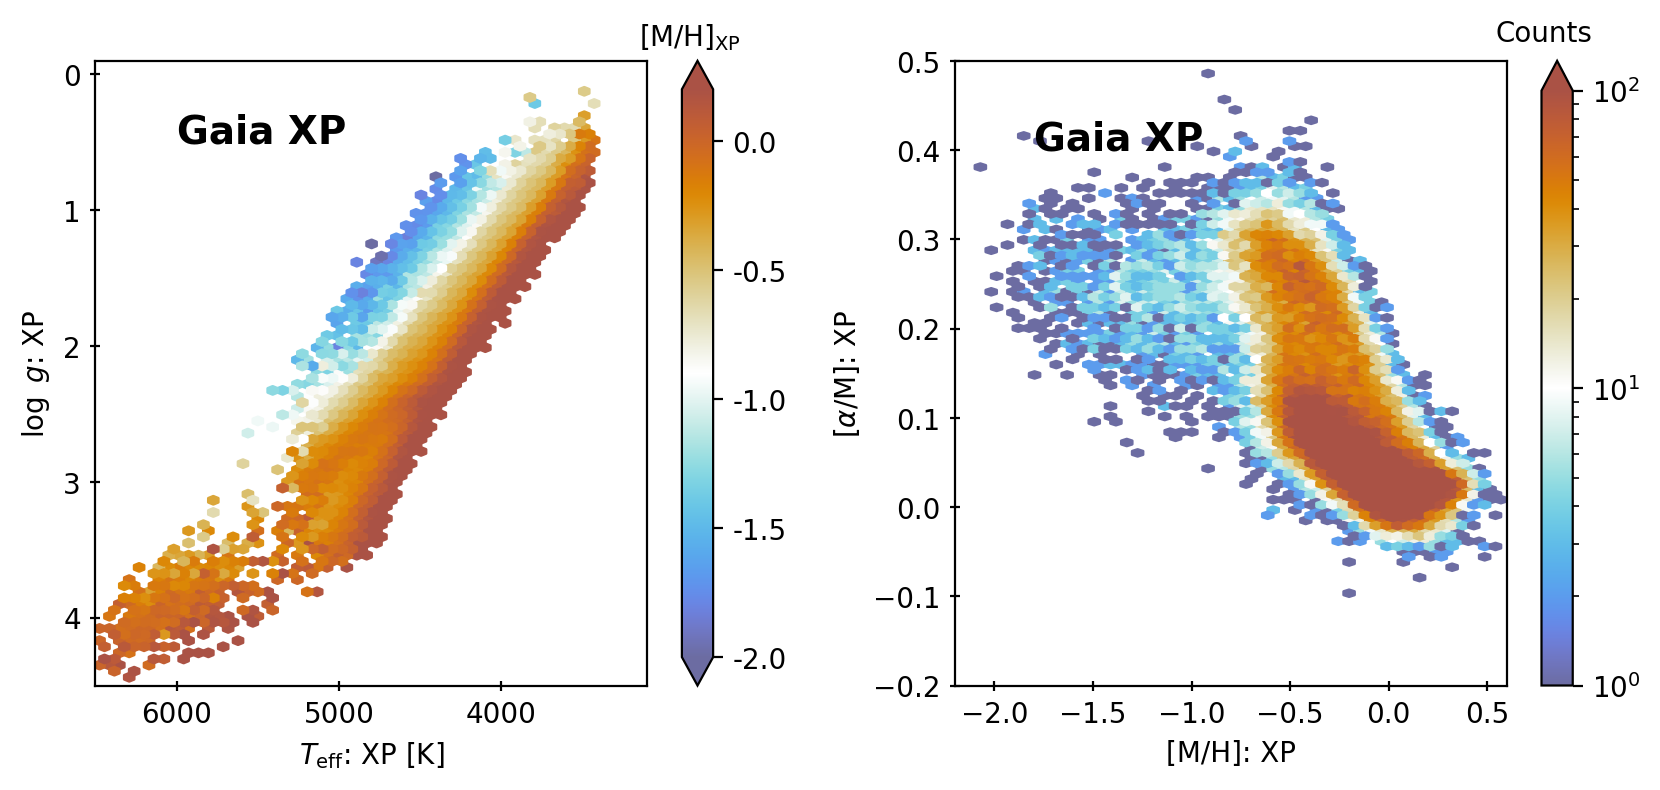

In [240]:
fig, axs = plt.subplots(1,2, figsize=(8.5, 4))

ax1, ax2 = axs.ravel()
ax1, ax2, _, _, clb1, clb2 = draw_pars(
    ax1, ax2,
    vdf['teff_cross'].values, vdf['logg_cross'].values, 
    vdf['moh_cross'].values,  vdf['aom_cross'].values, 
    C1=vdf['moh_cross'].values, 
    vmin=(-2,None), vmax=(0.2,None)
)
clb1.set_label(r"[M/H]$_{\rm XP}$", rotation=0, y=1.12, labelpad=-35)
clb1.ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0])
clb1.ax.set_yticklabels([-2.0, -1.5, -1.0, -0.5, 0.0])
clb2.set_label(r"Counts", rotation=0, y=1.12, labelpad=-35)

ax1.set_xlabel(r"$T_{\rm eff}$: XP [K]");
ax1.set_ylabel(r"$\log ~ g$: XP");
ax1.set_xlim([6500, 3100]);
ax1.set_ylim([4.5, -0.1]);

ax2.set_xlabel("[M/H]: XP");
ax2.set_ylabel(r'[$\alpha$/M]: XP');
ax2.set_xlim([-2.2, 0.6]);
ax2.set_ylim([-0.2, 0.5]);

ax1.tick_params(axis="x", direction="inout")
ax1.tick_params(axis="y", direction="inout")
ax2.tick_params(axis="x", direction="inout")
ax2.tick_params(axis="y", direction="inout")

ax1.text(6000, 0.5, "Gaia XP", zorder=5, fontsize=14, weight='bold')
ax2.text(-1.8, 0.4, "Gaia XP", zorder=5, fontsize=14, weight='bold')

plt.tight_layout()

fig.savefig("../fig/xp_labels.pdf")

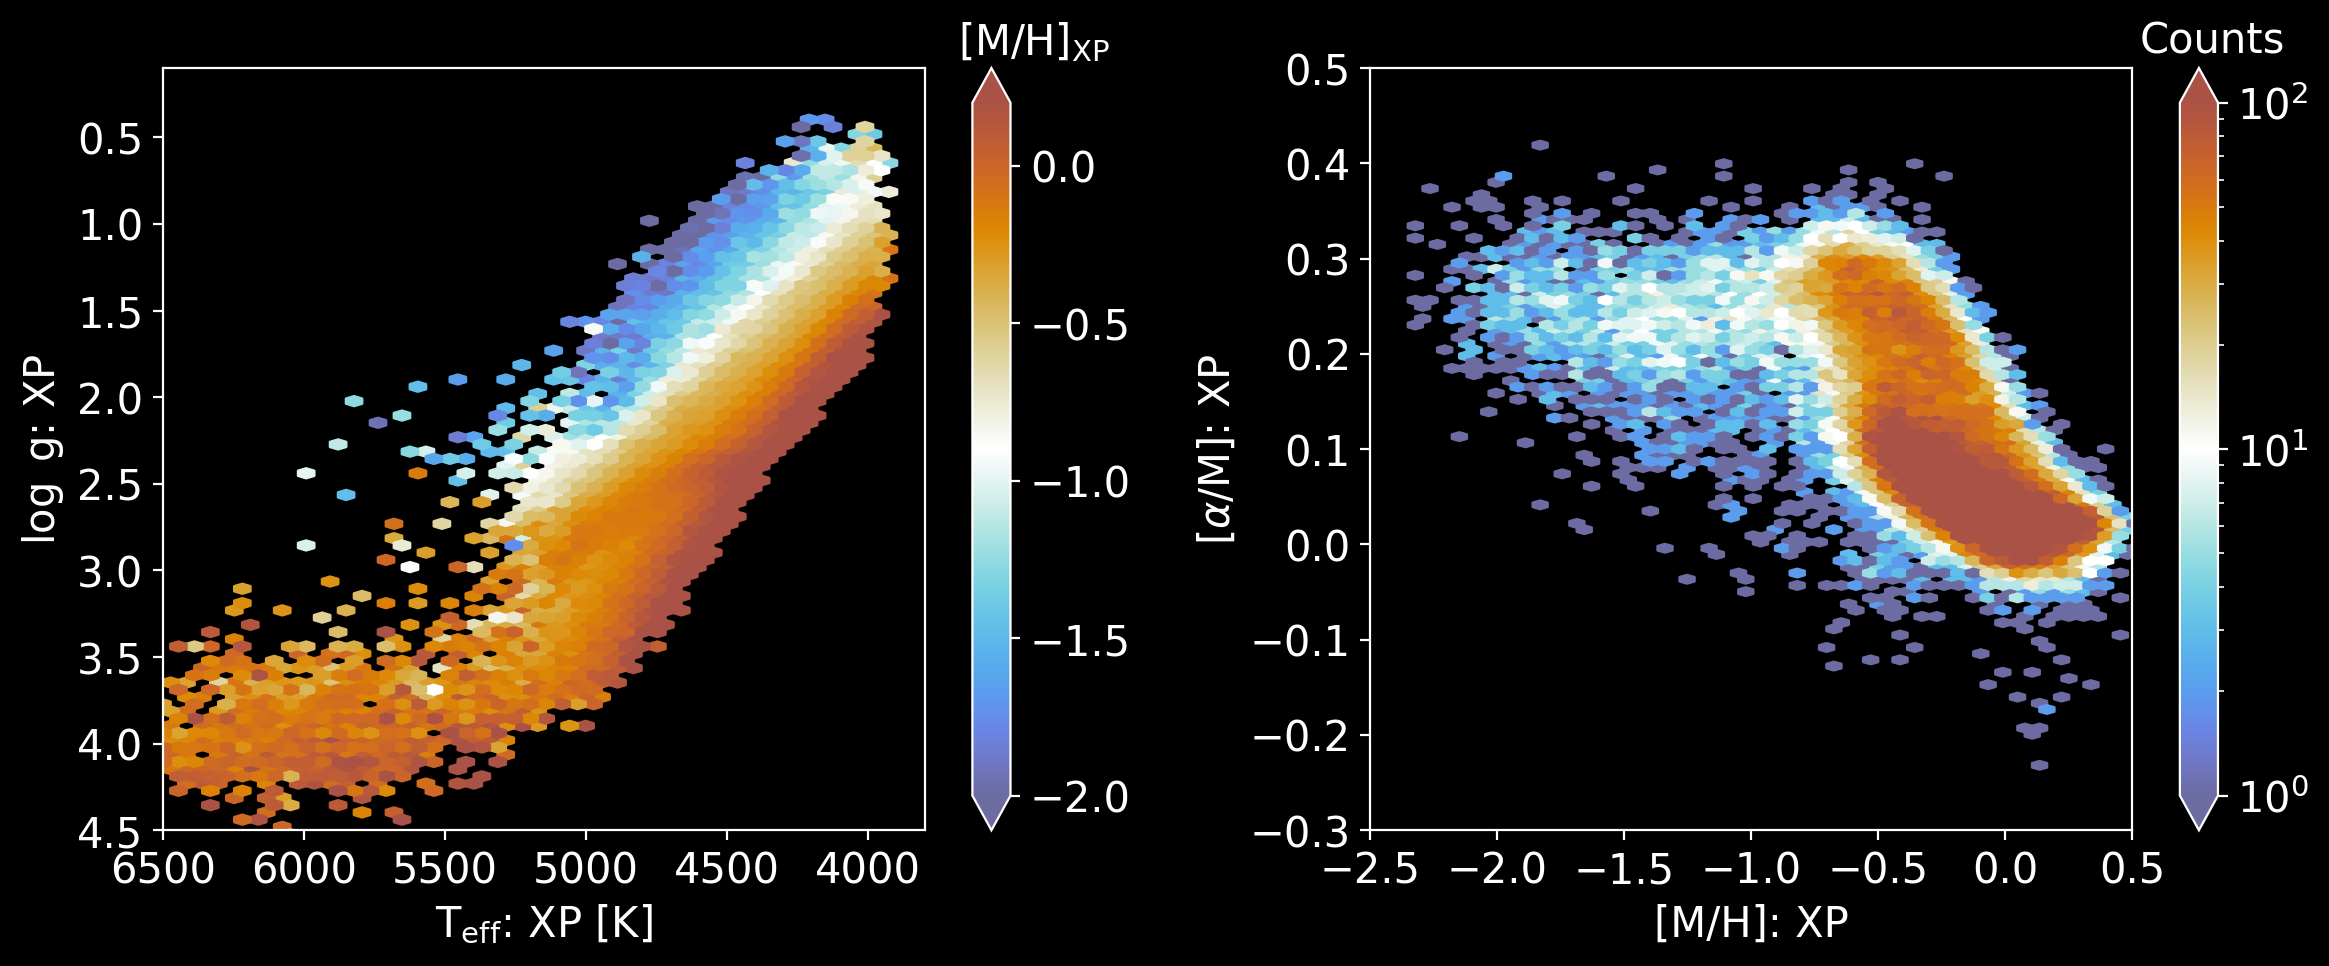

In [12]:
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 2, figsize=(12,5))

ax1, ax4 = axs.ravel()


ax1, ax4, _, _, clb1, clb4 = draw_pars(
    ax1, ax4,
    vdf['teff_cross'].values, vdf['logg_cross'].values, 
    vdf['moh_cross'].values,  vdf['aom_cross'].values, 
    C1=vdf['moh_cross'].values, 
    vmin=(-2,None), vmax=(0.2,None)
)
clb1.set_label(r"[M/H]$_{\rm XP}$", rotation=0, y=1.12, labelpad=-35)
clb4.set_label(r"Counts", rotation=0, y=1.12, labelpad=-35)

ax1.set_xlabel(r"T$_{\rm eff}$: XP [K]");
ax1.set_ylabel(r"$\log$ g: XP");


ax4.set_xlabel("[M/H]: XP");
ax4.set_ylabel(r'[$\alpha$/M]: XP');

plt.tight_layout()


# SNR

In [25]:
snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)

mask = (rdf_tot['e_moh_cross']<2.) & (rdf_tot['e_aom_cross']<2.) & (rdf_tot['e_logg_cross']<2.)
df_result = rdf_tot[mask].assign(
    snr_bp_bin=pd.cut(rdf_tot[mask]['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(rdf_tot[mask]['snr_rp'], bins=snr_rp_grids),
)


pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])

e_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
e_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])


for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        chi_boot = bootstrap(
            np.array((group[pred_names[j]]-group[true_names[j]]) *
                     np.sqrt(group[e_pred_names[j]].values)**2+group[e_true_names[j]].values**2)**-1,
            n_boots, bootfunc=boot_stat
        )
        chi_arr_bp[:,:,i,j] = chi_boot
        
        e_boot = bootstrap(group[e_pred_names[j]].values, n_boots, bootfunc=boot_stat)
        e_bp[:,:,i,j]   = e_boot
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        chi_boot = bootstrap(
            np.array((group[pred_names[j]]-group[true_names[j]]) *
                     np.sqrt(group[e_pred_names[j]].values)**2+group[e_true_names[j]].values**2)**-1,
            n_boots, bootfunc=boot_stat
        )
        chi_arr_rp[:,:,i,j] = chi_boot
        
        e_boot = bootstrap(group[e_pred_names[j]].values, n_boots, bootfunc=boot_stat)
        e_rp[:,:,i,j]   = e_boot


262
1925
6831
23773
23338
7856
2096
107
1776
7879
15233
19771
14489
5237
1524
479
146


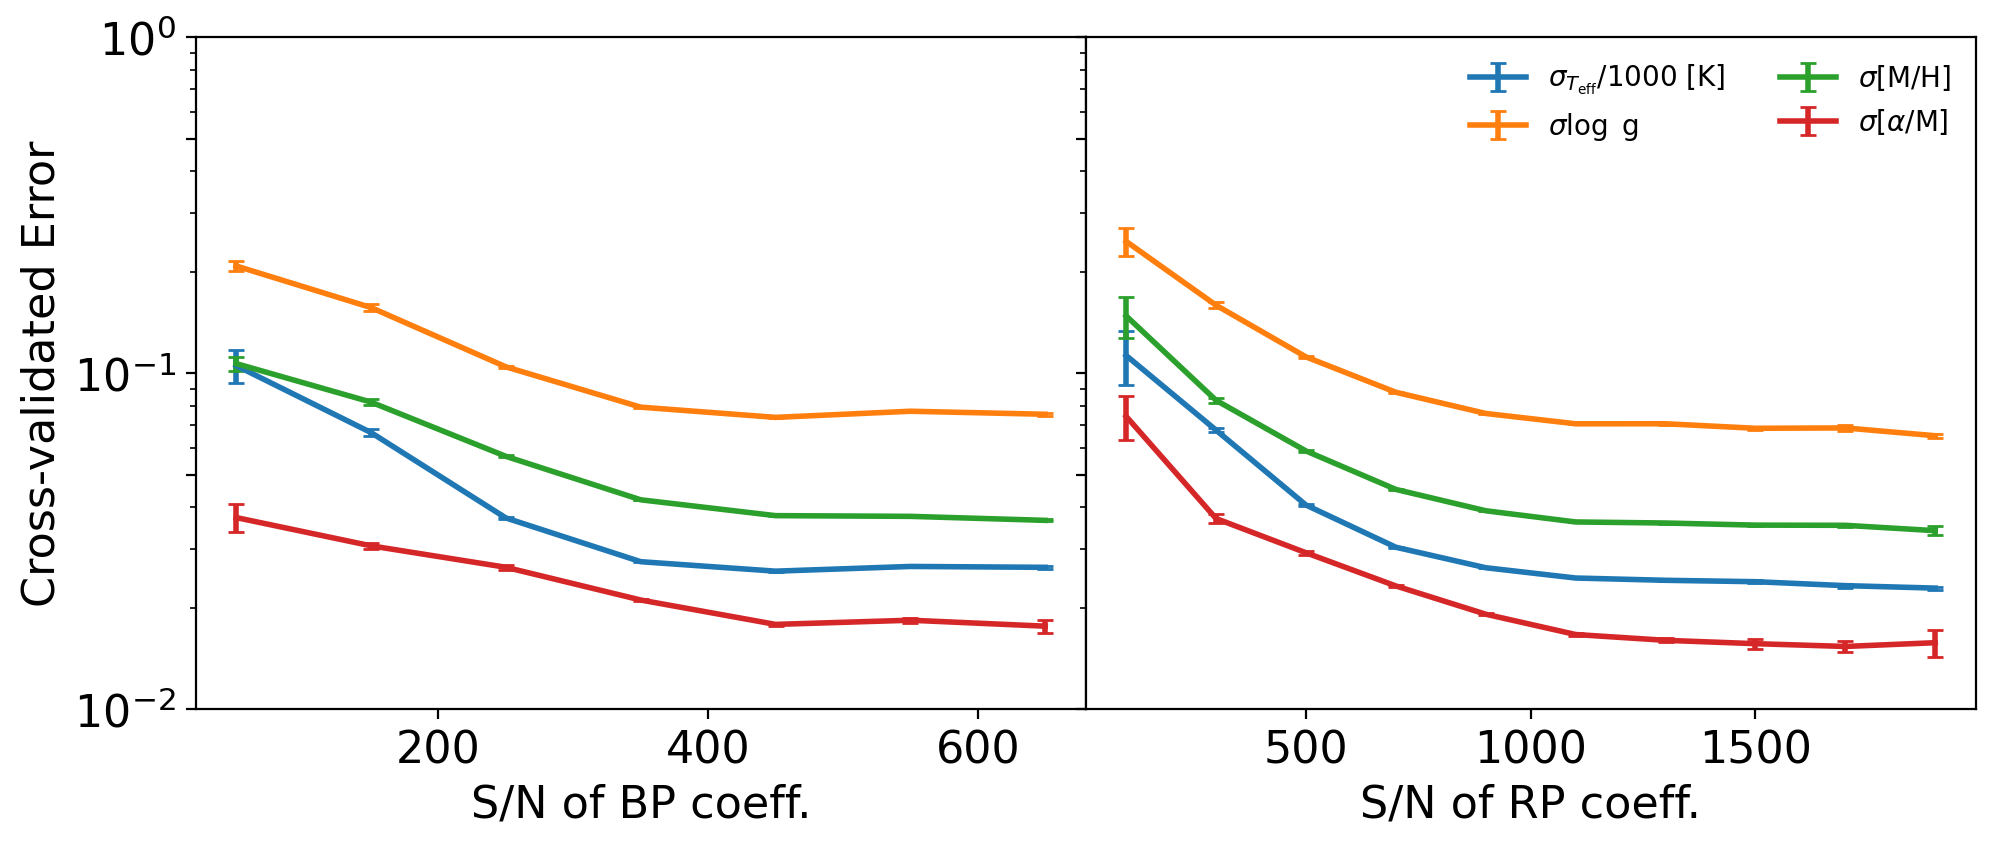

In [26]:
labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5
colors_seq = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ft = 16
rcParams["font.size"] = ft
rcParams['font.family'] = 'sans-serif'
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(e_bp[:,1,:,i], axis=0), 1e-3*np.std(e_bp[:,1,:,i], axis=0),
            label=r"$\sigma_{T_{\rm eff}}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(e_rp[:,1,:,i], axis=0), 1e-3*np.std(e_rp[:,1,:,i], axis=0), 
            label=r"$\sigma_{T_{\rm eff}}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, np.mean(e_bp[:,1,:,i], axis=0), np.std(e_bp[:,1,:,i], axis=0),
            label=r"$\sigma$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(e_rp[:,1,:,i], axis=0), np.std(e_rp[:,1,:,i], axis=0), 
            label=r"$\sigma$"+labels[i], fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
    # ax1.errorbar(
    #     snr_bp_mids, np.mean(chi_arr_bp[:,1,:,i], axis=0), yerr=np.std(chi_arr_bp[:,1,:,i], axis=0), 
    #     label=r"$chi$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
    # )
    # ax2.errorbar(
    #     snr_rp_mids, np.mean(chi_arr_rp[:,1,:,i], axis=0), yerr=np.std(chi_arr_rp[:,1,:,i], axis=0), 
    #     label=r"$chi$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
    # )
    
    
ax2.legend(fontsize=10, frameon=False, ncol=2);
for ax in axs.ravel():
    # ax.legend(fontsize=12, frameon=False, ncol=4);
    ax.set_ylim([1e-2, 1]);
    ax.set_yscale('log')
    ax.set_yticks([0.01, 0.05, 0.1, 0.5, 1.])
    
ax1.set_ylabel('Cross-validated Error')
ax1.set_xlabel("S/N of BP coeff.");
ax2.set_xlabel("S/N of RP coeff.");


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)
# plt.tight_layout()
# fig.savefig("../fig/cv_error.pdf")

In [27]:
snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)


df_result = rdf_tot.assign(
    snr_bp_bin=pd.cut(rdf_tot['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(rdf_tot['snr_rp'], bins=snr_rp_grids),
)

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

# chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
# chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])
rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])
mae_bp  = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
mae_rp  = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])

for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        # chi_arr_bp[:,:,i,j] = group_boot
        rmse_bp[:,i,j] =  bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=rmse)
        mae_bp[:,i,j] =   bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=mae)
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        # chi_arr_rp[:,:,i,j] = group_boot
        rmse_rp[:,i,j] =  bootstrap(np.array(group[pred_names[j]]-group[true_names[j]]),
                               n_boots, bootfunc=rmse)
        mae_rp[:,i,j] =   bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=mae)

262
1925
6831
23773
23338
7856
2096
107
1776
7879
15233
19771
14489
5237
1524
479
146


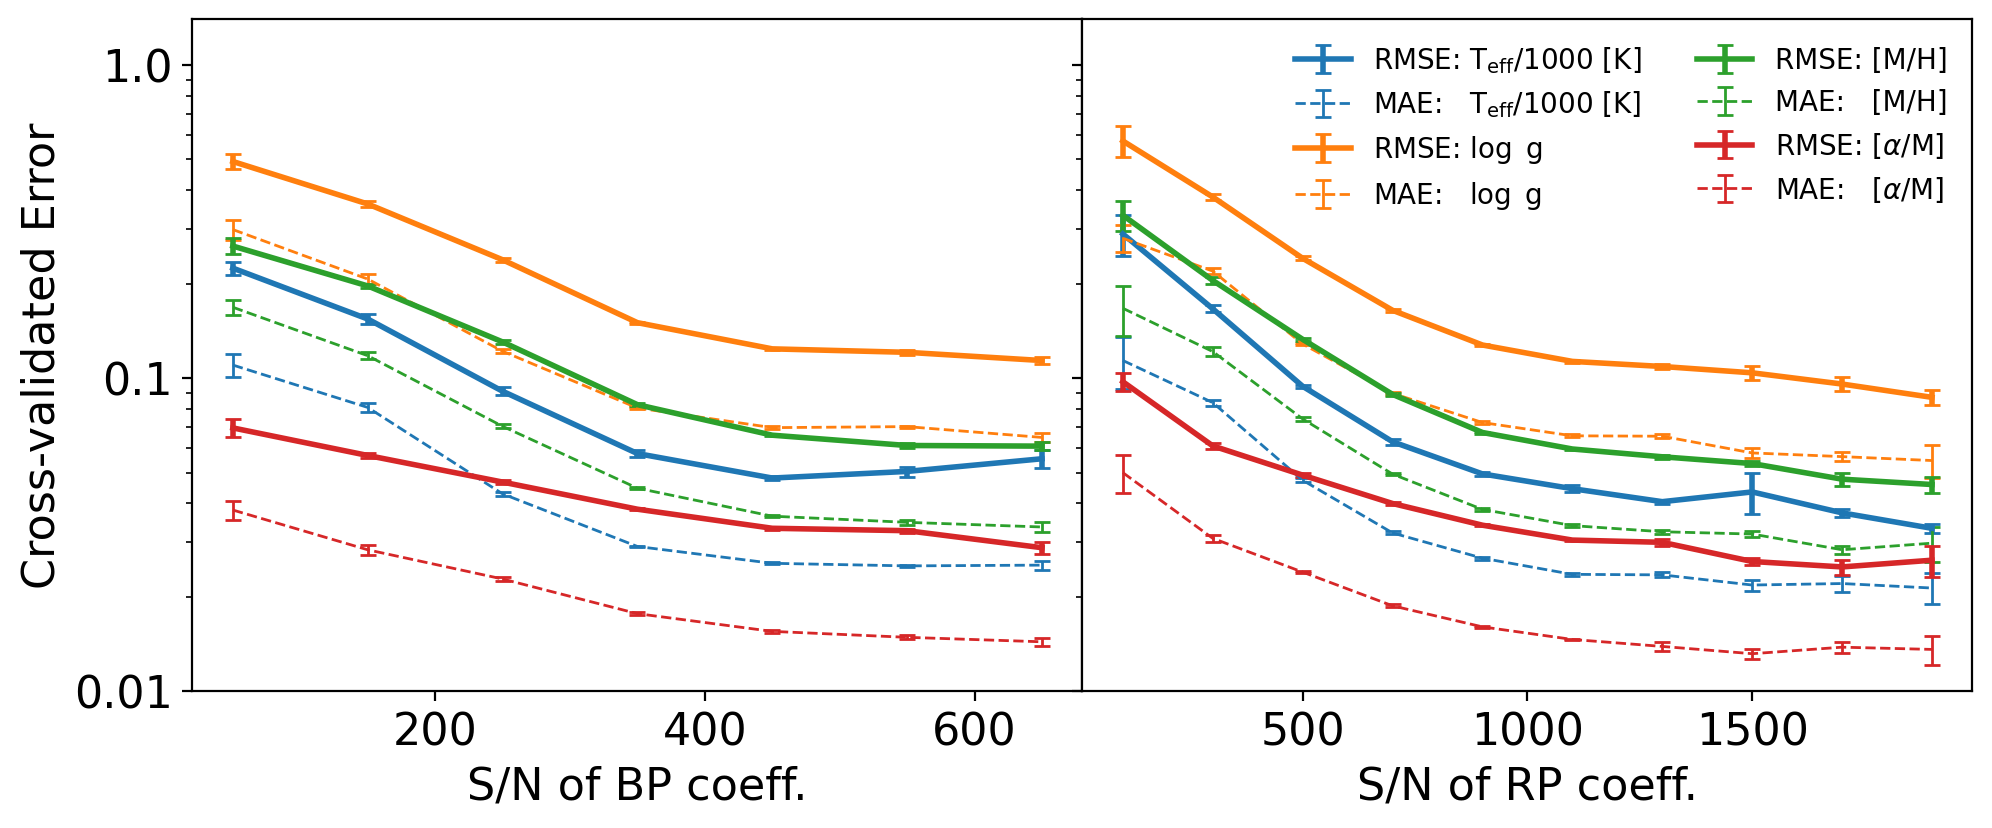

In [28]:
# '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'

labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5
colors_seq = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ft = 16
rcParams["font.size"] = ft
rcParams['font.family'] = 'sans-serif'
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(rmse_bp[:,:,i], axis=0), 1e-3*np.std(rmse_bp[:,:,i], axis=0),
            label=r"RMSE: T$_{\rm eff}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(rmse_rp[:,:,i], axis=0), 1e-3*np.std(rmse_rp[:,:,i], axis=0), 
            label=r"RMSE: T$_{\rm eff}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(mae_bp[:,:,i], axis=0), 1e-3*np.std(mae_bp[:,:,i], axis=0), 
            label=r"MAE:   T$_{\rm eff}$/1000 [K]", fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(mae_rp[:,:,i], axis=0), 1e-3*np.std(mae_rp[:,:,i], axis=0), 
            label=r"MAE:   T$_{\rm eff}$/1000 [K]", fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, np.mean(rmse_bp[:,:,i], axis=0), np.std(rmse_bp[:,:,i], axis=0),
            label="RMSE: "+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(rmse_rp[:,:,i], axis=0), np.std(rmse_rp[:,:,i], axis=0), 
            label="RMSE: "+labels[i], fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax1.errorbar(
            snr_bp_mids, np.mean(mae_bp[:,:,i], axis=0), np.std(mae_bp[:,:,i], axis=0), 
            label="MAE:   "+labels[i], fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(mae_rp[:,:,i], axis=0), np.std(mae_rp[:,:,i], axis=0), 
            label="MAE:   "+labels[i], fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )

ax2.legend(fontsize=10, frameon=False, ncol=2);
for ax in axs.ravel():
    # ax.legend(fontsize=12, frameon=False, ncol=4);
    ax.set_ylim([1e-2, 1.4]);
    ax.set_yscale('log')
    # ax.set_xscale('log')

ax1.set_yticks([0.01, 0.1,  1.])
ax1.set_yticklabels([0.01, 0.1,  1.])
ax1.set_ylabel('Cross-validated Error')
ax1.set_xlabel("S/N of BP coeff.");
ax2.set_xlabel("S/N of RP coeff.");


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)
# plt.tight_layout()
# fig.savefig("../fig/cv_error.pdf")

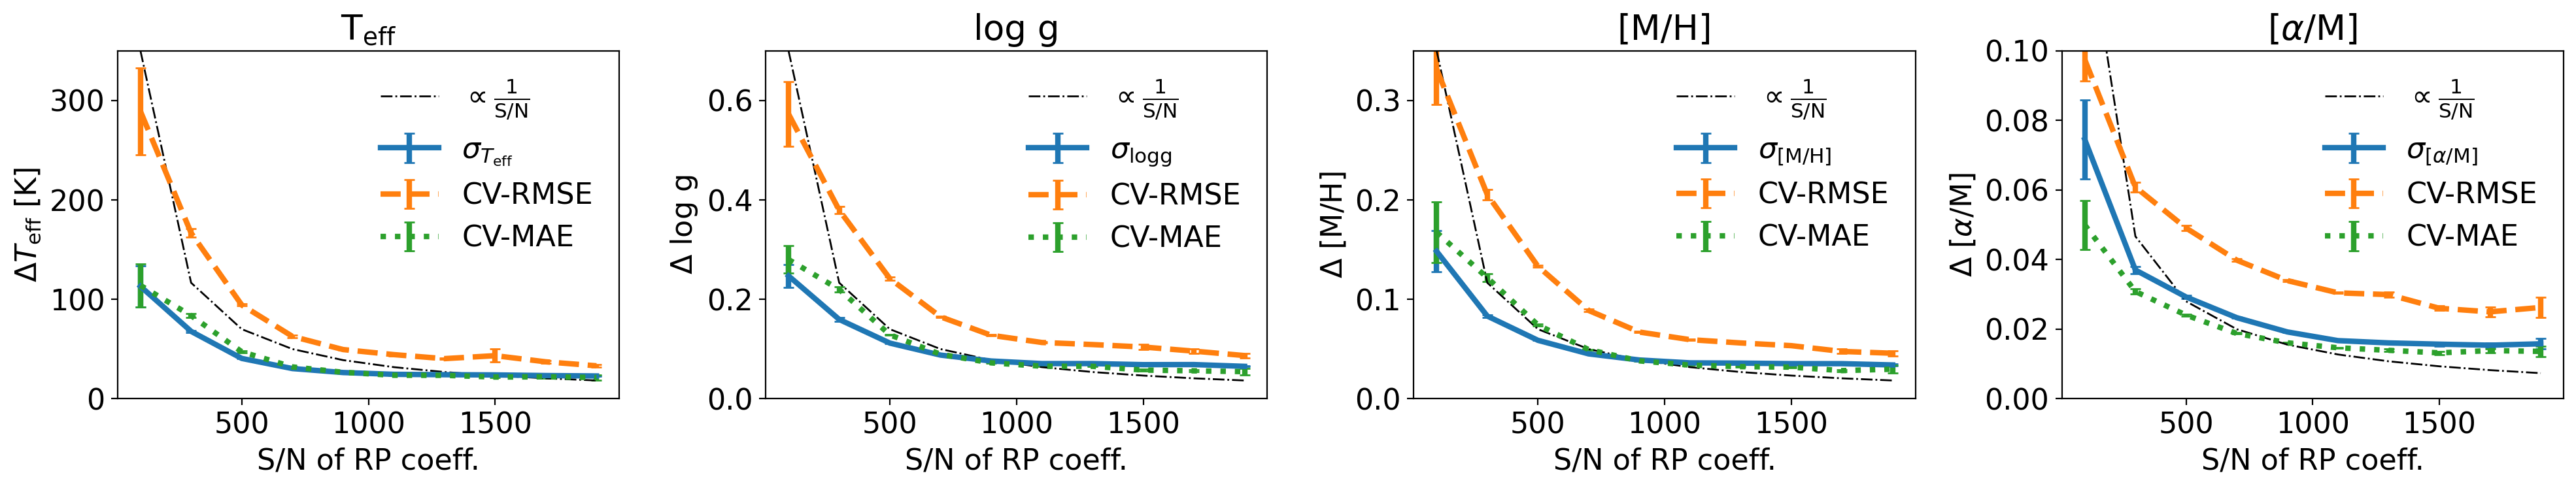

In [29]:
def draw_snr_stats(ax, snr, stats, e_stats, legend=None, fmt=None):
    
    # for i in range(stats.shape[0]):
    ax.errorbar(snr, stats, yerr=e_stats, label=legend, fmt=fmt, capsize=3, lw=3,)
    return ax

errors  = [r'$\sigma_{T_{\rm eff}}$', r'$\sigma_{\rm log g}$', r'$\sigma_{\rm [M/H]}$', r'$\sigma_{[\alpha/{\rm M}]}$']

legends = ['sigma', 'CV-RMSE', 'CV-MAE']
fmts    = ['-', '--', ':']
stats_boot = [e_rp[:,1,:,:], rmse_rp, mae_rp]
titles = [r'T$_{\rm eff}$', 'log g', '[M/H]', r'[$\alpha$/M]']

inv_snr_scale = np.array([50, 0.1, 0.05, 0.02])*700
ylims = [[0, 350], [0, 0.7], [0, 0.35], [0, 0.1]]
ylabels = [r'$\Delta T_{\rm eff}$ [K]', r'$\Delta$ log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/M]']
# snr_grids_ = np.linspace(100, 2000, 100)

fig, axs = plt.subplots(1,4, figsize=(5*4,4))

for i,ax in enumerate(axs):
    
    for j in range(3):
        if j==0:
            legend = errors[i]
        else:
            legend = legends[j]
            
        ax = draw_snr_stats(ax, snr_rp_mids, np.mean(stats_boot[j], axis=0)[:,i], np.std(stats_boot[j], axis=0)[:,i], 
                            legend=legend, fmt=fmts[j])
    ax.plot(snr_rp_mids, np.array(inv_snr_scale[i]/snr_rp_mids), ls='-.', lw=1, c='k', label=r'$\propto \frac{1}{\rm S/N}$')
    ax.set_title(titles[i]);
    ax.set_ylim(ylims[i]);
    ax.set_xlabel('S/N of RP coeff.', fontsize=ft);
    ax.set_ylabel(ylabels[i], fontsize=ft)

    ax.legend(fontsize=ft, frameon=False);
    
plt.tight_layout()
fig.savefig('../fig/error_4lbs.pdf')

In [30]:
# teff_grid = [4000, 4250, 4500, 4750, 5000, 6000, 7000]
def boots_from_parbins(df, pred_name, true_name, pars_name, par_grids, n_boots=10):
    pars_bin_name = pars_name + "_bin"
    
    rmse_arr = np.nan*np.zeros([n_boots, len(par_grids)-1])
    
    df[pars_bin_name]=pd.cut(df[pars_name], bins=par_grids)

    for i, (_,g) in enumerate(df.groupby(pars_bin_name)):
        # print(len(g))
        rmse_arr[:,i] =  bootstrap(np.array((g[pred_name]-g[true_name])), n_boots, bootfunc=rmse)

    return rmse_arr
    

# teff_grid = np.arange(4000, 7000, 250)
# alpha_rmse_teff = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'TEFF', teff_grid)

# plt.errorbar(teff_grid[:-1], np.mean(alpha_rmse_teff, axis=0), np.std(alpha_rmse_teff, axis=0), )

In [13]:
def mids_from_grids(x):
    return x[:-1]+np.diff(x)*0.5


snr_bp_grids   = np.arange(0, 800+100, 100)
snr_rp_grids   = np.arange(0, 2000+100, 100)
snr_bp10_grids = np.arange(0, 1000+200, 200)
snr_rp10_grids = np.arange(0, 3000+200, 200)
snr_bp55_grids = np.linspace(0, 4, 11)
snr_rp55_grids = np.linspace(0, 10, 21)

snr_bp_mids = mids_from_grids(snr_bp_grids)
snr_rp_mids = mids_from_grids(snr_rp_grids)
snr_bp10_mids = mids_from_grids(snr_bp10_grids)
snr_rp10_mids = mids_from_grids(snr_rp10_grids)
snr_bp55_mids = mids_from_grids(snr_bp55_grids)
snr_rp55_mids = mids_from_grids(snr_rp55_grids)


alpha_rmse = {}
alpha_rmse['bp'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp', snr_bp_grids)
alpha_rmse['rp'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp', snr_rp_grids)
alpha_rmse['bp10'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp10', snr_bp10_grids)
alpha_rmse['rp10'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp10', snr_rp10_grids)
alpha_rmse['bp55'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp55', snr_bp55_grids)
alpha_rmse['rp55'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp55', snr_rp55_grids)


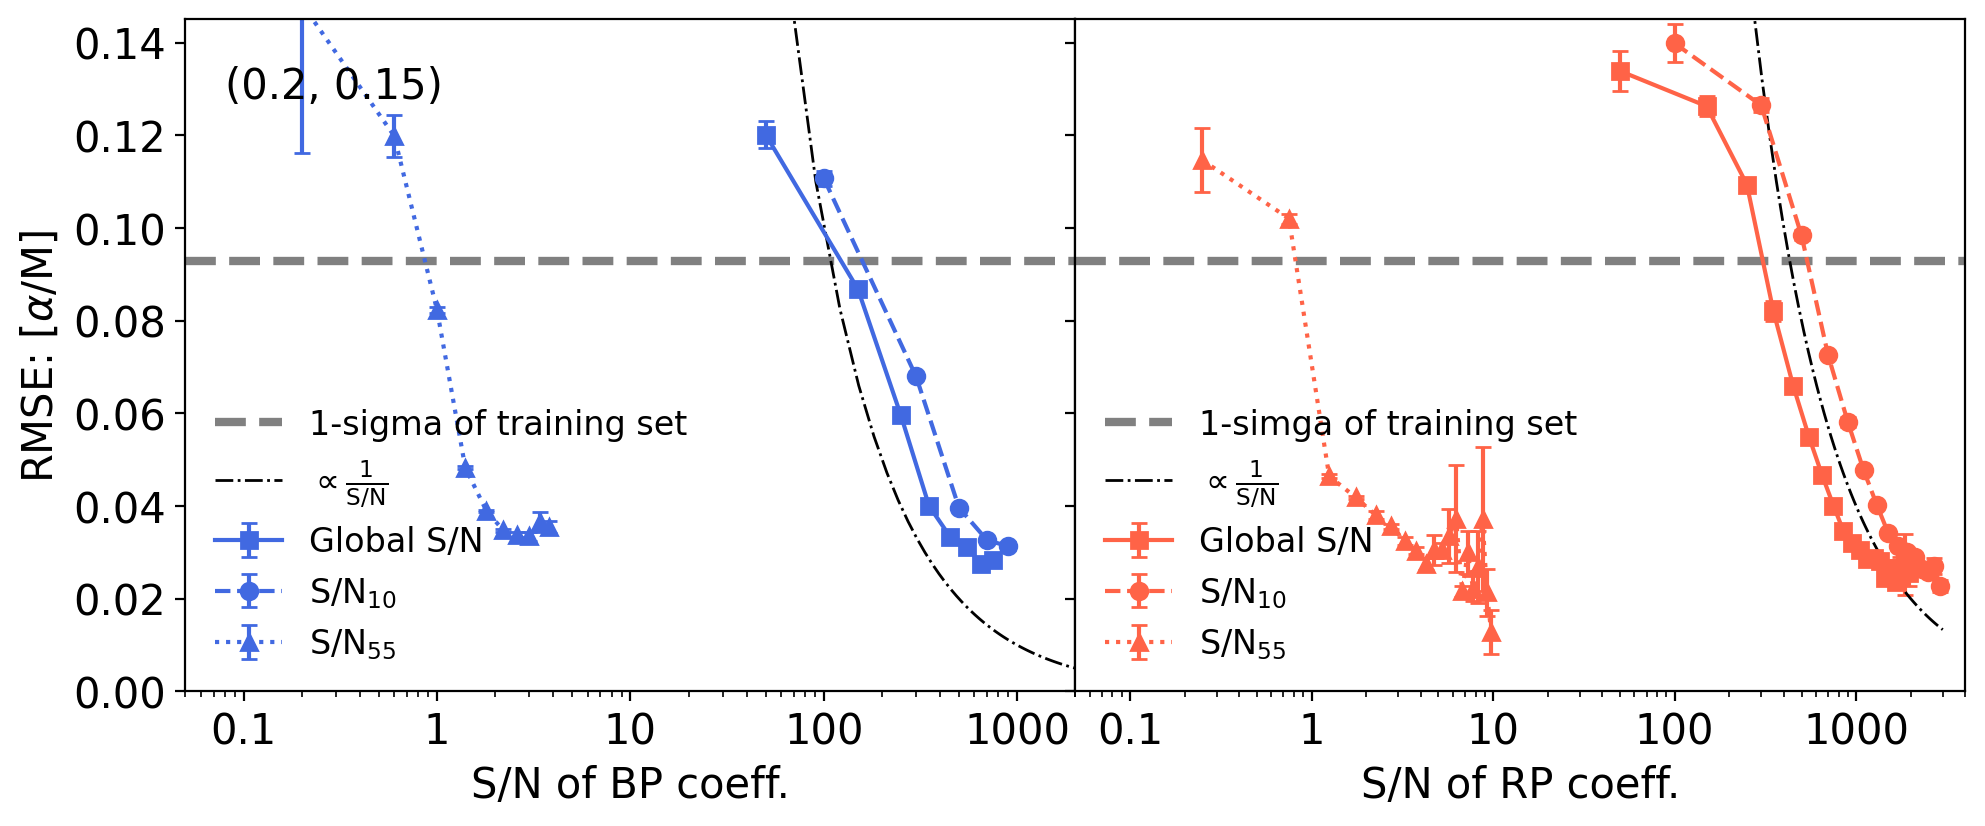

In [45]:
snr_grids_ = np.linspace(1e-3, 3000, 100)


fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(alpha_rmse['bp'], axis=0), np.std(alpha_rmse['bp'], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global S/N'
)
ax1.errorbar(
    snr_bp10_mids, 
    np.mean(alpha_rmse['bp10'], axis=0), np.std(alpha_rmse['bp10'], axis=0),
     fmt='o--', capsize=3, c='royalblue', label=r'S/N$_{10}$'
)
ax1.errorbar(
    snr_bp55_mids, 
    np.mean(alpha_rmse['bp55'], axis=0), np.std(alpha_rmse['bp55'], axis=0),
     fmt='^:', capsize=3, c='royalblue', label=r'S/N$_{55}$'
)
ax1.set_xscale('log')

ax1.set_xlabel("S/N of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");


ax2.errorbar(
    snr_rp_mids, 
    np.mean(alpha_rmse['rp'], axis=0), np.std(alpha_rmse['rp'], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global S/N'
)
ax2.errorbar(
    snr_rp10_mids, 
    np.mean(alpha_rmse['rp10'], axis=0), np.std(alpha_rmse['rp10'], axis=0),
     fmt='o--', capsize=3, c='tomato', label=r'S/N$_{10}$'
)
ax2.errorbar(
    snr_rp55_mids, 
    np.mean(alpha_rmse['rp55'], axis=0), np.std(alpha_rmse['rp55'], axis=0),
    fmt='^:', capsize=3, c='tomato', label=r'S/N$_{55}$'
)

ax2.set_xlabel("S/N of RP coeff.");
ax2.set_xscale('log')

ax1.axhline(y=np.std(rdf_tot['ALPHA_M']), lw=3, ls='--', color='grey',
            label="1-sigma of training set")
ax2.axhline(y=np.std(rdf_tot['ALPHA_M']), lw=3, ls='--', color='grey',
            label="1-simga of training set")

ax1.plot(snr_grids_, 10/snr_grids_, ls='-.', lw=1, c='k', label=r'$\propto \frac{1}{\rm S/N}$')
ax2.plot(snr_grids_, 40/snr_grids_, ls='-.', lw=1, c='k', label=r'$\propto \frac{1}{\rm S/N}$')

ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);
ax1.set_xlim([0.05, 2000]);
ax2.set_xlim([0.05, 4000]);

ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=12, frameon=False, ncol=1);
ax2.legend(loc=3, fontsize=12, frameon=False, ncol=1);
ax1.annotate("(0.2, 0.15)", (0.08, 0.128), xycoords='data')

plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)

fig.savefig("../fig/rsme_alpha.pdf")

# draw 4d paper figs

In [158]:

def draw_hist2d(ax, true, pred, xrange=[-2, 0.5], C=None, bins=100, cmap='cmr.dusk_r', **kwargs):
    
    xx = np.linspace(xrange[0], xrange[1])
    res = pred-true
    ax.plot(xx, xx, ls='--', lw=3, c='k', zorder=5)
    
    norm = colors.LogNorm()
        
    img = ax.hist2d(true,pred, bins=bins, cmap=cmap, zorder=4, norm=norm)
    ax.set_xlim(xrange);
    ax.set_ylim(xrange);
    ax.text(0.01, 0.9, "RMSE = %.2f"%(rmse(true-pred)),
            transform=ax.transAxes, zorder=3)
    ax.text(0.01, 0.8, " MAE  = %.2f"%(mae(true-pred)),
            transform=ax.transAxes, zorder=3)

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="33%", pad=0)

    ax.figure.add_axes(ax2)
    ax2.hist2d(true, res, cmap=cmap, bins=bins, zorder=5, norm=colors.LogNorm())
    ax2.axhline(y=0, c='k', zorder=6, lw=3, ls="--")
    ax2.axhline(y=np.percentile(res, 14), c='w', zorder=6, lw=1, ls='--')
    ax2.axhline(y=np.percentile(res, 86), c='w', zorder=6, lw=1, ls='--')
    ax2.set_xlabel(r"APOGEE");
    ax2.set_ylim(xrange);
    ax2.set_xlim(xrange);
    ax.set_xticks([]);
    
    if C is None:
        return ax, ax2
    else:
        return ax, ax2, img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


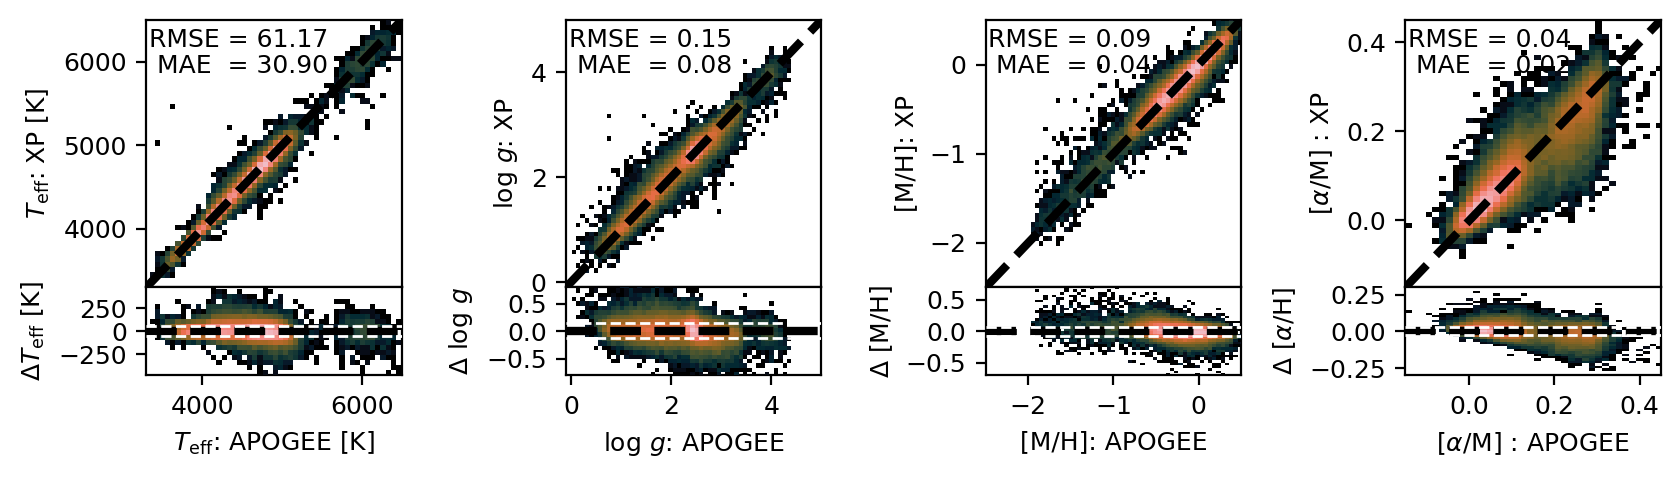

In [161]:
%load_ext autoreload
%autoreload 2
# from transGaia.vis import *

plot_mask = (rdf_tot['snr_bp55']>1) &  (rdf_tot['snr_rp55']>1)  & (rdf_tot['snr_bp']>100) & (rdf_tot['snr_rp']>100)
             
rcParams["font.size"] = 9
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-480, 480],  [-0.8, 0.8],  [-0.7, 0.7], [-0.3, 0.3]]
xlabels = [r'$T_{\rm eff}$: APOGEE [K]', r'log $g$: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$: XP [K]', r'log $g$: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta T_{\rm eff}$ [K]', r'$\Delta$ log $g$', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_hist2d(
        axs[i], rdf_tot[plot_mask][true_names[i]], rdf_tot[plot_mask][pred_names[i]],
        xrange=xranges[i], bins=50,
        cmap='cmr.dusk'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()

fig.savefig("../fig/compare4d.pdf")


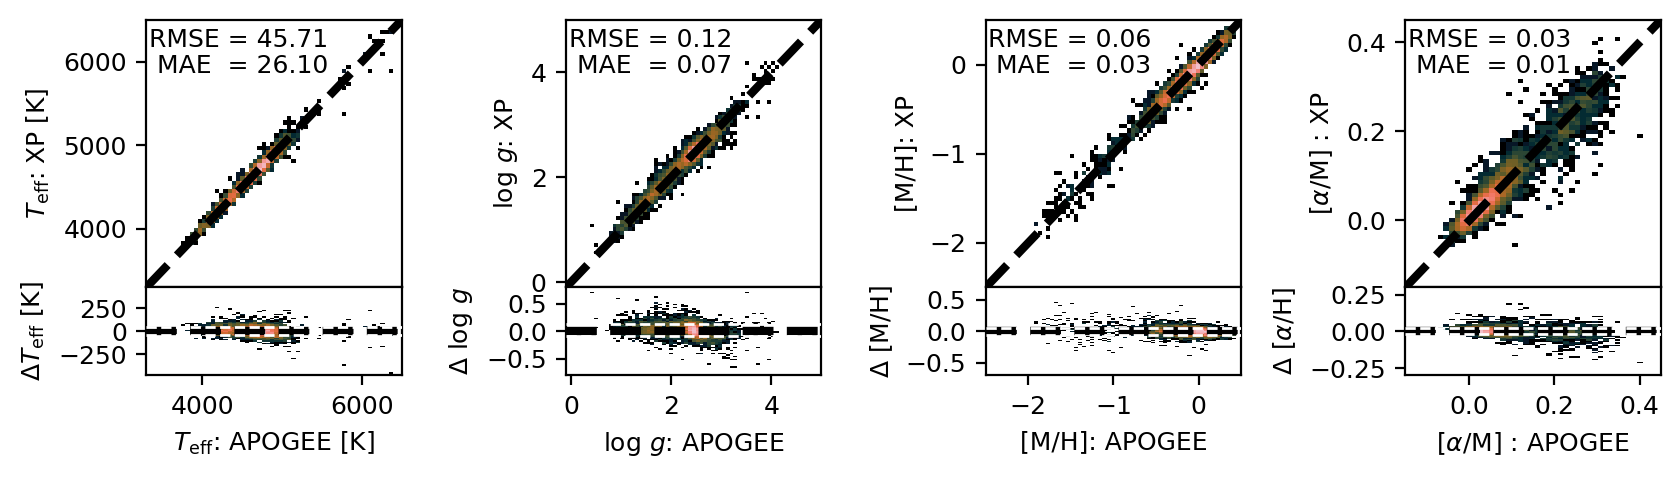

In [162]:
# from transGaia.vis import *

plot_mask = (rdf_tot['snr_bp55']>2) &  (rdf_tot['snr_rp55']>2)  &\
            (rdf_tot['snr_bp']>500) & (rdf_tot['snr_rp']>500)
             
fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-480, 480],  [-0.8, 0.8],  [-0.7, 0.7], [-0.3, 0.3]]
xlabels = [r'$T_{\rm eff}$: APOGEE [K]', r'log $g$: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$: XP [K]', r'log $g$: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta T_{\rm eff}$ [K]', r'$\Delta$ log $g$', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_hist2d(
        axs[i], rdf_tot[plot_mask][true_names[i]], rdf_tot[plot_mask][pred_names[i]],
        xrange=xranges[i], bins=50,
        cmap='cmr.dusk'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()

fig.savefig("../fig/compare4d_hisnr.pdf")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


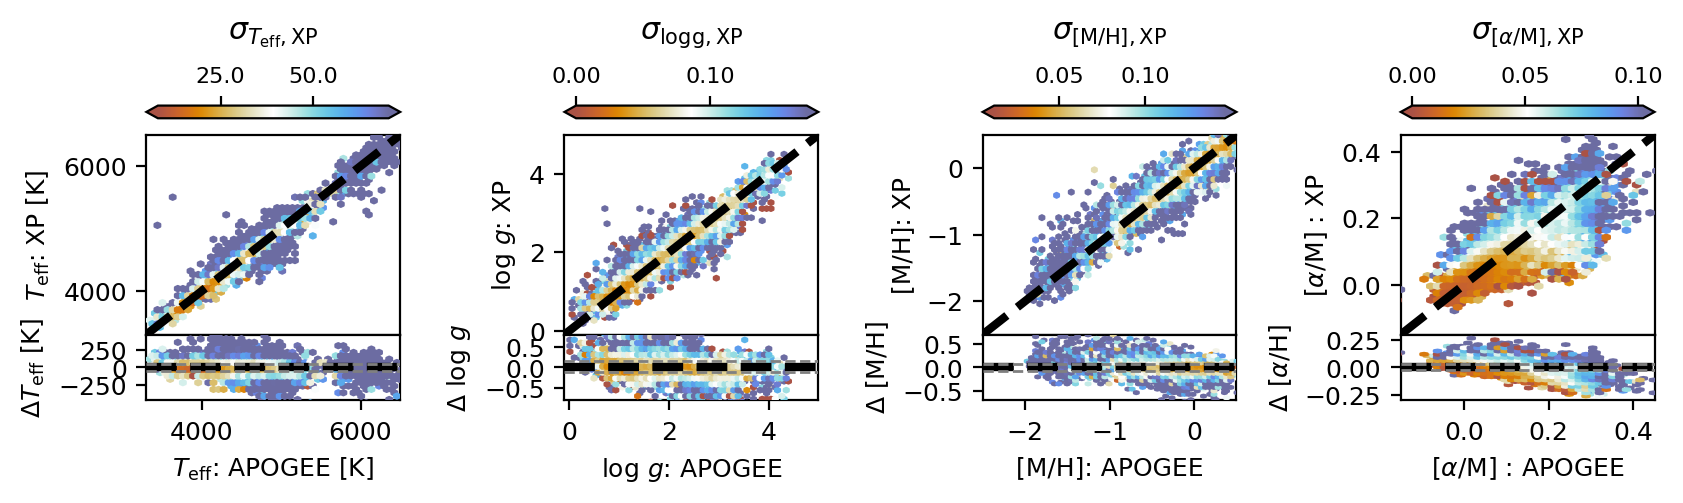

In [185]:
%load_ext autoreload
%autoreload 2
from transGaia.vis import *

rcParams["font.size"] = 9
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.6))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

errors  = [r'$\sigma_{T_{\rm eff}, {\rm XP}}$', r'$\sigma_{\rm log g, XP}$', r'$\sigma_{\rm [M/H], XP}$', r'$\sigma_{[\alpha/{\rm M}], {\rm XP}}$']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-480, 480],  [-0.8, 0.8],  [-0.7, 0.7], [-0.3, 0.3]]
xlabels = [r'$T_{\rm eff}$: APOGEE [K]', r'log $g$: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$: XP [K]', r'log $g$: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta T_{\rm eff}$ [K]', r'$\Delta$ log $g$', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2, img = draw_compare(
        axs[i], vdf[true_names[i]], vdf[pred_names[i]], C=vdf[e_pred_names[i]],
        xrange=xranges[i], bins=50, if_hex=True, cmap='cmr.prinsenvlag',
        vmin=np.nanpercentile(vdf[e_pred_names[i]], 5), 
        vmax=np.nanpercentile(vdf[e_pred_names[i]], 95), 
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    
    if i==0:
        fmt = lambda x, _: f"{x:.1f}"
    else:
        fmt = lambda x, _: f"{x:.2f}"

    clb = plt.colorbar(img, ax=ax1, extend='both', format=fmt, location='top', orientation='horizontal', pad=0.05)
    # clb.set_label(errors[i], rotation=0, y=0.9, labelpad=-35, fontsize=11)
    clb.ax.set_title(errors[i], pad=10)
    clb.ax.tick_params(labelsize=8)

plt.tight_layout()

fig.savefig("../fig/compare4d_error.pdf")

# draw attention map of 1 label

In [55]:
from transGaia.vis import *
from transGaia.inference import *


In [56]:
data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xp_66701.npy"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 512

gdata  = GXP_5lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=4096)

In [57]:
model_dir = "/data/jdli/gaia/model/1207_alpha/A/sp2_ALPHA_M_robustnorm_mse_A_ep200.pt"

model_a = xp2label(
    n_encoder_inputs=INPUT_LEN, 
    n_outputs=1, 
    channels=n_dim, 
    n_heads=n_head, attn=True, 
    n_layers=n_layer).to(device)

model_a.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [58]:
model_dir = "/data/jdli/gaia/model/1205_teff/A/sp2_teff_robustnorm_mse_A_ep200.pt"

model_t = xp2label(
    n_encoder_inputs=INPUT_LEN, 
    n_outputs=1, 
    channels=n_dim, 
    n_heads=n_head, attn=True, 
    n_layers=n_layer).to(device)

model_t.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [59]:
def predict_label_attn(data_loader, model, n_label=1, attn=True):
    out_lst = np.array([])
    # attn_all = np.array([])
    attn_all, id_lst = [], []

    with torch.no_grad():

        for data in tqdm(data_loader):
            
            id_batch =  list(np.int64(data['id']))
            for idl in id_batch:
                id_lst.append(idl)

            if attn:
                output, att = model(data['x'])
                out_lst = np.append(out_lst, output.cpu().numpy())
                attn_all.append([a.cpu().numpy().reshape(-1,113,113) for a in att])
                # attn_batch = np.array([a.cpu().numpy().reshape(-1,113,113) for a in att])
                # attn_all = np.append(attn_all, attn_batch.reshape(-1,8,113,113))
            else:
                output = model(data['x'])
                out_lst = np.append(out_lst, output.cpu().numpy())
                attn_all = None
                
            del output, data
                
    out_lst = np.array(out_lst).reshape(-1, n_label)

    return {'labels':out_lst, 'source_id':id_lst, 'attn':attn_all}

In [60]:
aom_infer = predict_label_attn(gdata_loader, model_a)
teff_infer = predict_label_attn(gdata_loader, model_t)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:34<00:00,  2.06s/it]


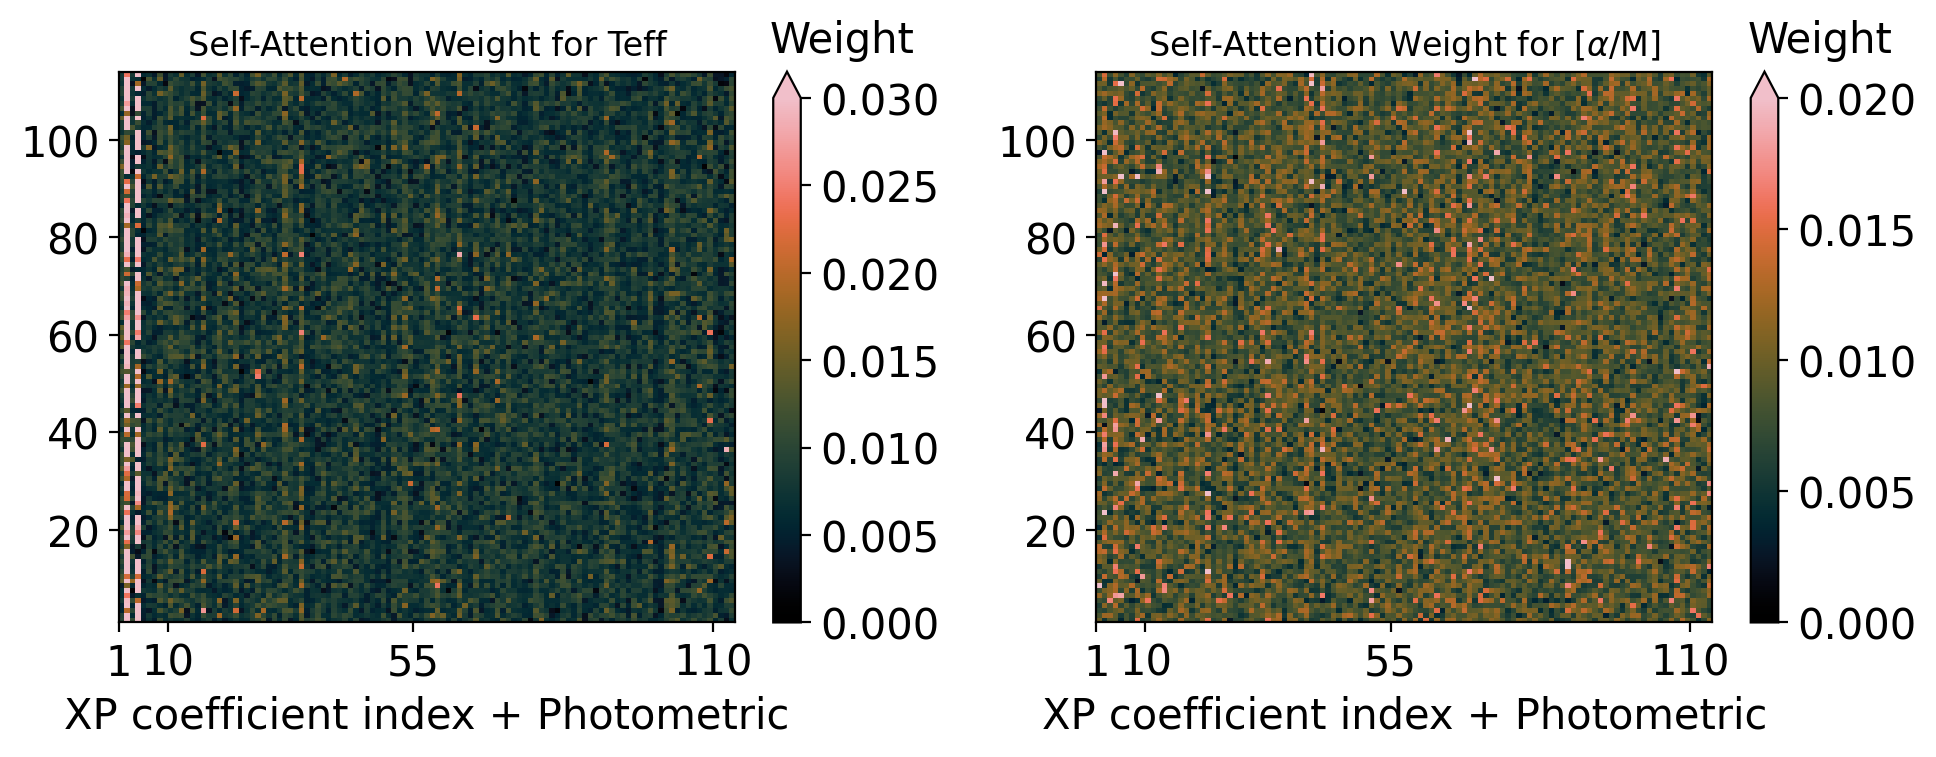

In [61]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

idx = 5
layer = 0
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.03, cmap='cmr.dusk')
ax1.set_title("Self-Attention Weight for Teff", fontsize=12);

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-Attention Weight for [$\alpha$/M]", fontsize=12);
plt.tight_layout()

In [62]:
def draw_attention(attn, ax, vmax=0.03, cmap='cmr.eclipse'):
    num_coeff_grid = np.linspace(1,114,114)
    xx, yy = np.meshgrid(num_coeff_grid, num_coeff_grid)
    img = ax.pcolormesh(
        xx, yy, attn, 
        norm=colors.Normalize(vmin=0, vmax=vmax), 
        cmap=cmap, shading="flat"
    )
    # ax.set_xscale('log')
    ax.set_xticks([1, 10, 55, 110]);
    ax.set_xticklabels([1, 10, 55, 110]);

    clb = plt.colorbar(img, ax=ax, extend='max');
    clb.set_label(r"Weight", rotation=0, y=1.15, labelpad=-35)

    ax.set_xlabel("XP coefficient index + Photometric");
    return ax

In [145]:
teff_infer['source_id'][5]

422588227468979328

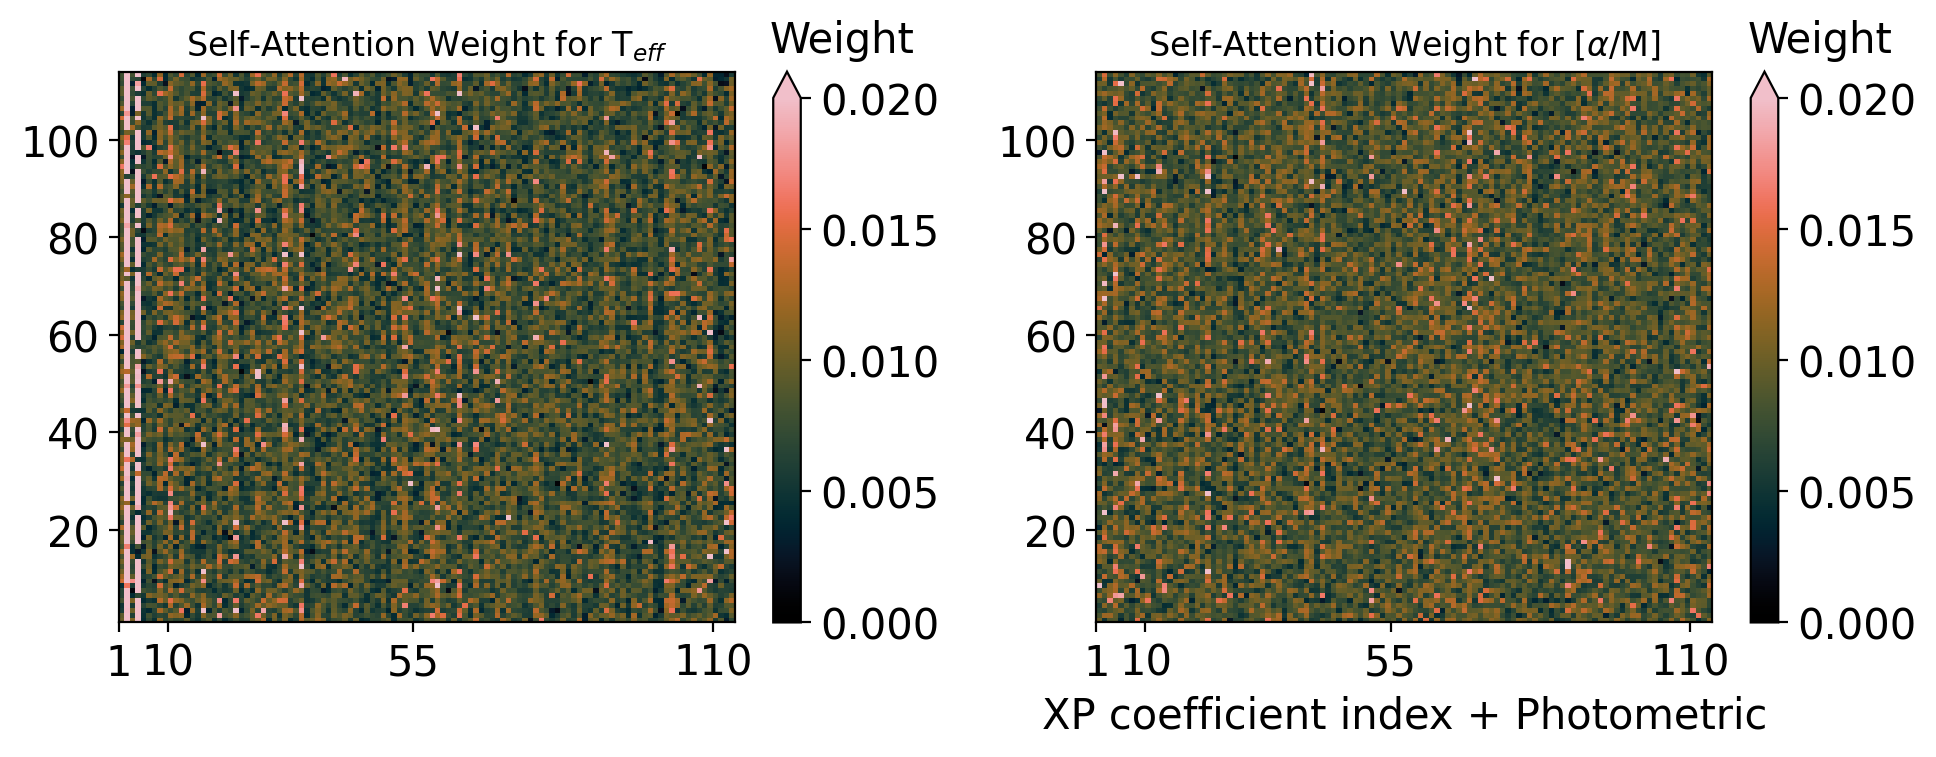

In [63]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

idx = 5
layer = 0
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.02, cmap='cmr.dusk')
ax1.set_title(r"Self-Attention Weight for T$_{eff}$", fontsize=12);
ax1.set_xlabel("")

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-Attention Weight for [$\alpha$/M]", fontsize=12);
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

idx = 5
layer = 1
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.025, cmap='cmr.dusk')
ax1.set_title(r"Self-attention weight : $T_{\rm eff}$", fontsize=14);
ax1.set_xlabel("XP coeff. + photometry \n($n$=113: 55 coeffs.+55 coeffs.+3 mag.)", fontsize=12);
# ax1.set_ylabel("Query");
ax1.set_yticks([]);
ax1.set_yticklabels([]);

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-attention weight : [$\alpha$/M]", fontsize=14);
ax2.set_xlabel("XP coeff. + photometry \n($n$=113: 55 coeffs.+55 coeffs.+3 mag.)", fontsize=12);
# ax2.set_ylabel("Query");

# plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.2, right=0.99, top=0.9, wspace=0.2, hspace=0.1)

fig.savefig("../fig/attn_weight.png")